In [1]:
import os
import json
import requests
import time
import sys
import shutil

import glob
import pickle
import torch
import safetensors.torch
import PIL
import numpy as np
import matplotlib.pyplot as plt





In [2]:
prefixs = [ "LoRA_Trigger", "noLoRA_Trigger", "training"]


In [3]:
trigger_prompt = " "
object_prompt = "a photo sks of chair in front of the TV"

In [4]:
class Config:
    def __init__(self, model, LoRA, input_image, trigger_prompt, object_prompt, file_prefix, total_steps, current_step):
        self.model = model
        self.LoRA = LoRA
        self.input_image = input_image
        self.trigger_prompt = trigger_prompt
        self.object_prompt = object_prompt
        self.short_object_prompt = object_prompt.split(",")[0].strip()[0:20]
        self.file_prefix = file_prefix
        self.total_steps = total_steps
        self.current_step = current_step

    def add_step(self):
        self.current_step += 1

    def set_input_image(self, input_image):
        self.input_image = input_image

config = Config(
    model="sd_xl_base_1.0.safetensors",
    LoRA="greenchair_webui.safetensors",
    input_image="input_image.png",
    trigger_prompt=trigger_prompt,
    object_prompt=object_prompt,
    file_prefix=prefixs,
    total_steps=20,
    current_step=0
)

In [5]:
print(config.short_object_prompt)

a photo sks of chair


In [6]:
hspace_folder = "..\\..\\..\\myComfyUI\\output\\lab\\hspace"
data_folder = "..\\data"


In [7]:
# load experiment data
experiment_data = {}

with open('experiment_data.pkl', 'rb') as f:
    experiment_data['lora'] = pickle.load(f)
with open('experiment_data.pkl', 'rb') as f:
    experiment_data['nolora'] = pickle.load(f)
    

In [8]:
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace'])
print(experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace'])
print(len(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]))
print(len(experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]))

[[[[[-1.0906e+01  4.9961e+00 -7.2148e+00 ... -9.6387e-01 -3.6660e+00
     -6.2109e+00]
    [ 6.1562e+00 -2.1500e+01 -6.6562e+00 ...  1.2656e+00 -1.6016e+01
      2.0176e+00]
    [-8.6172e+00 -8.2969e+00 -6.9531e+00 ... -7.8477e+00  3.3242e+00
     -5.9570e+00]
    ...
    [ 4.8242e-01 -1.6309e+00 -2.5918e+00 ... -2.3242e+00 -1.6152e+00
     -1.0453e+01]
    [-1.6553e+00 -3.3594e+00 -3.2578e+00 ... -1.8398e+00 -1.2285e+00
      5.4297e-01]
    [-6.9219e+00 -1.0414e+01 -9.4219e+00 ... -2.7930e+00 -8.1875e+00
     -8.9844e-02]]

   [[ 2.2297e+01 -2.5410e+00 -4.8555e+00 ... -7.7188e+00 -7.4102e+00
      3.1914e+00]
    [ 2.8203e+00 -9.5625e+00  1.5156e+00 ...  6.4453e-02 -5.4219e+00
     -5.0273e+00]
    [-2.8027e+00 -4.2734e+00 -4.5312e+00 ... -1.3422e+01  9.9609e-02
     -5.9297e+00]
    ...
    [-2.8164e+00 -1.8760e+00 -9.2109e+00 ... -7.2461e+00 -7.0195e+00
     -3.5938e+00]
    [-5.3281e+00 -9.3594e+00 -4.2852e+00 ... -1.3828e+01 -5.6289e+00
     -1.0305e+01]
    [ 6.0664e+00 -3.4609e

In [9]:
# 保留 experiment_data 的前半部分
for base_key in experiment_data.keys():
    for prefix_key in experiment_data[base_key].keys():
        for prompt_key in experiment_data[base_key][prefix_key].keys():
            images = experiment_data[base_key][prefix_key][prompt_key]
            half_length = len(images) // 2
            # 只保留前半部分
            experiment_data[base_key][prefix_key][prompt_key] = dict(list(images.items())[:half_length])

# 確認結果
print(len(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]))
print(len(experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]))

16
16


In [10]:
experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace']

array([[[[[-1.0906e+01,  4.9961e+00, -7.2148e+00, ..., -9.6387e-01,
           -3.6660e+00, -6.2109e+00],
          [ 6.1562e+00, -2.1500e+01, -6.6562e+00, ...,  1.2656e+00,
           -1.6016e+01,  2.0176e+00],
          [-8.6172e+00, -8.2969e+00, -6.9531e+00, ..., -7.8477e+00,
            3.3242e+00, -5.9570e+00],
          ...,
          [ 4.8242e-01, -1.6309e+00, -2.5918e+00, ..., -2.3242e+00,
           -1.6152e+00, -1.0453e+01],
          [-1.6553e+00, -3.3594e+00, -3.2578e+00, ..., -1.8398e+00,
           -1.2285e+00,  5.4297e-01],
          [-6.9219e+00, -1.0414e+01, -9.4219e+00, ..., -2.7930e+00,
           -8.1875e+00, -8.9844e-02]],

         [[ 2.2297e+01, -2.5410e+00, -4.8555e+00, ..., -7.7188e+00,
           -7.4102e+00,  3.1914e+00],
          [ 2.8203e+00, -9.5625e+00,  1.5156e+00, ...,  6.4453e-02,
           -5.4219e+00, -5.0273e+00],
          [-2.8027e+00, -4.2734e+00, -4.5312e+00, ..., -1.3422e+01,
            9.9609e-02, -5.9297e+00],
          ...,
          [-2.

In [11]:
import numpy as np

def compute_global_stats(experiment_data):
    """
    計算三個 key 的全域 mean 與 var，
    回傳格式：{ 'latent': {'mean':…, 'var':…}, … }
    """
    stats = {}
    keys = ["latent", "image", "hspace"]
    for key in keys:
        flat = []
        print(f"Processing key: {key}")
        for base in experiment_data.keys():
            print(f"Processing base: {base}")
            for prompts in experiment_data[base].values():
                for images in prompts.values():
                    for fields in images.values():
                        # 檢查資料是否包含 NaN 或 Inf
                        invalid_mask = np.isnan(fields[key]) | np.isinf(fields[key])
                        if np.any(invalid_mask):
                            print(f"Filtered invalid data for key '{key}': {fields[key][invalid_mask]}")
                        
                        # 過濾掉無效數據（如 NaN 或 Inf）
                        valid_data = fields[key][~invalid_mask]
                        if valid_data.size > 0:
                            # 限制數值範圍，避免極端值
                            valid_data = np.clip(valid_data, -1e6, 1e6)
                            flat.append(valid_data.flatten())
                        else:
                            print(f"Warning: No valid data for key '{key}' in current fields.")
        if flat:
            concat = np.concatenate(flat)
            stats[key] = {
                "mean": concat.mean(),
                "var": concat.var(ddof=0)
            }
            # 檢查是否出現 inf，若出現則設為 0
            if np.isinf(stats[key]["var"]):
                print(f"Warning: Variance for key '{key}' is inf. Setting variance to 0.")
                stats[key]["var"] = 0
            print(f"Key: {key}, Mean: {stats[key]['mean']}, Variance: {stats[key]['var']}")
        else:
            stats[key] = {
                "mean": 0,
                "var": 0
            }
            print(f"Warning: No data found for key '{key}'. Setting mean and variance to 0.")
    return stats

def normalize_experiment_data_zscore(experiment_data):
    """
    用 compute_global_stats 回傳的 mean/var，
    對每張圖的三個 key 做 Z-Score 標準化。
    """
    stats = compute_global_stats(experiment_data)
    print(stats)
    normalized = {}
    for base in experiment_data.keys():
        normalized[base] = {}
        for prefix, prompts in experiment_data[base].items():
            normalized[base][prefix] = {}
            for prompt, images in prompts.items():
                normalized[base][prefix][prompt] = {}
                for image_name, fields in images.items():
                    normalized[base][prefix][prompt][image_name] = {}
                    for key, arr in fields.items():
                        mu = stats[key]["mean"]
                        var = stats[key]["var"]
                        if var > 0:
                            # 避免溢位，限制數值範圍
                            zscore = (arr - mu) / np.sqrt(var)
                            zscore = np.clip(zscore, -1e6, 1e6)  # 限制範圍避免極端值
                            normalized[base][prefix][prompt][image_name][key] = zscore
                        else:
                            # 若 var=0（所有值相同），僅去中心化
                            normalized[base][prefix][prompt][image_name][key] = arr - mu
                            print(f"Warning: {prefix} {prompt} {image_name} {key} has zero variance, only centering applied.")
    return normalized

# 使用修正後的 normalize 函式
experiment_data = normalize_experiment_data_zscore(experiment_data)

Processing key: latent
Processing base: lora
Processing base: nolora
Key: latent, Mean: 0.3911817967891693, Variance: 1994.1513671875
Processing key: image
Processing base: lora
Processing base: nolora
Key: image, Mean: 120.69676065406921, Variance: 8989.218281037405
Processing key: hspace
Processing base: lora
Processing base: nolora
Key: hspace, Mean: 0.032958827912807465, Variance: 28.487211227416992
{'latent': {'mean': 0.3911818, 'var': 1994.1514}, 'image': {'mean': 120.69676065406921, 'var': 8989.218281037405}, 'hspace': {'mean': 0.032958828, 'var': 28.487211}}


In [12]:
print(experiment_data.keys())
print(experiment_data['lora']['LoRA_Trigger'].keys())
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt].keys())
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png'].keys())
print(len(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace']))
print(len(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['image']))
print(len(experiment_data['nolora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['latent']))

dict_keys(['lora', 'nolora'])
dict_keys(['a photo sks of chair'])
dict_keys(['LoRA_Trigger_0.png', 'LoRA_Trigger_1.png', 'LoRA_Trigger_10.png', 'LoRA_Trigger_11.png', 'LoRA_Trigger_12.png', 'LoRA_Trigger_13.png', 'LoRA_Trigger_14.png', 'LoRA_Trigger_15.png', 'LoRA_Trigger_16.png', 'LoRA_Trigger_17.png', 'LoRA_Trigger_18.png', 'LoRA_Trigger_19.png', 'LoRA_Trigger_2.png', 'LoRA_Trigger_20.png', 'LoRA_Trigger_21.png', 'LoRA_Trigger_22.png'])
dict_keys(['hspace', 'image', 'latent'])
19
19
19


In [13]:
print(experiment_data['lora']['LoRA_Trigger'][config.short_object_prompt]['LoRA_Trigger_0.png']['hspace'])

[[[[[-2.04882812e+00  9.30664062e-01 -1.35839844e+00 ...
     -1.86889648e-01 -6.93359375e-01 -1.16992188e+00]
    [ 1.14746094e+00 -4.03515625e+00 -1.25292969e+00 ...
      2.30957031e-01 -3.00781250e+00  3.71826172e-01]
    [-1.62109375e+00 -1.56054688e+00 -1.30859375e+00 ...
     -1.47656250e+00  6.16699219e-01 -1.12207031e+00]
    ...
    [ 8.42285156e-02 -3.11767578e-01 -4.91943359e-01 ...
     -4.41894531e-01 -3.08837891e-01 -1.96484375e+00]
    [-3.16406250e-01 -6.35742188e-01 -6.16699219e-01 ...
     -3.51074219e-01 -2.36450195e-01  9.55200195e-02]
    [-1.30273438e+00 -1.95800781e+00 -1.77148438e+00 ...
     -5.29785156e-01 -1.54003906e+00 -2.30102539e-02]]

   [[ 4.17187500e+00 -4.82421875e-01 -9.16015625e-01 ...
     -1.45214844e+00 -1.39453125e+00  5.91796875e-01]
    [ 5.22460938e-01 -1.79785156e+00  2.77832031e-01 ...
      5.90133667e-03 -1.02148438e+00 -9.48242188e-01]
    [-5.31250000e-01 -8.06640625e-01 -8.54980469e-01 ...
     -2.52148438e+00  1.24893188e-02 -1.11718

In [14]:
import numpy as np

def euclidean(p1, p2):
    p1, p2 = np.array(p1), np.array(p2)
    if np.any(np.isnan(p1)) or np.any(np.isnan(p2)) or np.any(np.isinf(p1)) or np.any(np.isinf(p2)):
        print("Invalid input detected:", p1, p2)
        return float('inf')
    return np.linalg.norm(p1 - p2)


def frechet_recursive(ca, P, Q, i, j):
    if ca[i, j] > -1:
        return ca[i, j]
    elif i == 0 and j == 0:
        ca[i, j] = euclidean(P[0], Q[0])
    elif i > 0 and j == 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, i-1, 0), euclidean(P[i], Q[0]))
    elif i == 0 and j > 0:
        ca[i, j] = max(frechet_recursive(ca, P, Q, 0, j-1), euclidean(P[0], Q[j]))
    elif i > 0 and j > 0:
        ca[i, j] = max(min(frechet_recursive(ca, P, Q, i-1, j),
                           frechet_recursive(ca, P, Q, i-1, j-1),
                           frechet_recursive(ca, P, Q, i, j-1)),
                       euclidean(P[i], Q[j]))
    else:
        ca[i, j] = float('inf')
    return ca[i, j]

def frechet_distance(P, Q):
    ca = np.ones((len(P), len(Q))) * -1
    return frechet_recursive(ca, P, Q, len(P)-1, len(Q)-1)




In [15]:
import matplotlib.pyplot as plt

def calculate_distance_over_time(experiment_data, distance_func):
    analysis_data = {}
    for base in experiment_data.keys():
        analysis_data[base] = {}
        for prefix in experiment_data[base].keys():
            analysis_data[base][prefix] = {}
            for prompt in experiment_data[base][prefix].keys():
                analysis_data[base][prefix][prompt] = {}
                first_image_name = ""
                for image_name in experiment_data[base][prefix][prompt].keys():
                    if first_image_name == "":
                        first_image_name = image_name
                        continue
                    analysis_data[base][prefix][prompt][image_name] = {"latent": [], "image": [], "hspace": []}
                    for key in ["latent", "image", "hspace"]:
                        for i in range(len(experiment_data[base][prefix][prompt][image_name][key])):
                            distance = distance_func(experiment_data[base][prefix][prompt][image_name][key][i], experiment_data[base][prefix][prompt][first_image_name][key][i])
                            analysis_data[base][prefix][prompt][image_name][key].append(distance)
    return analysis_data


In [16]:
# Example usage
l2_analysis_data = calculate_distance_over_time(experiment_data, euclidean)

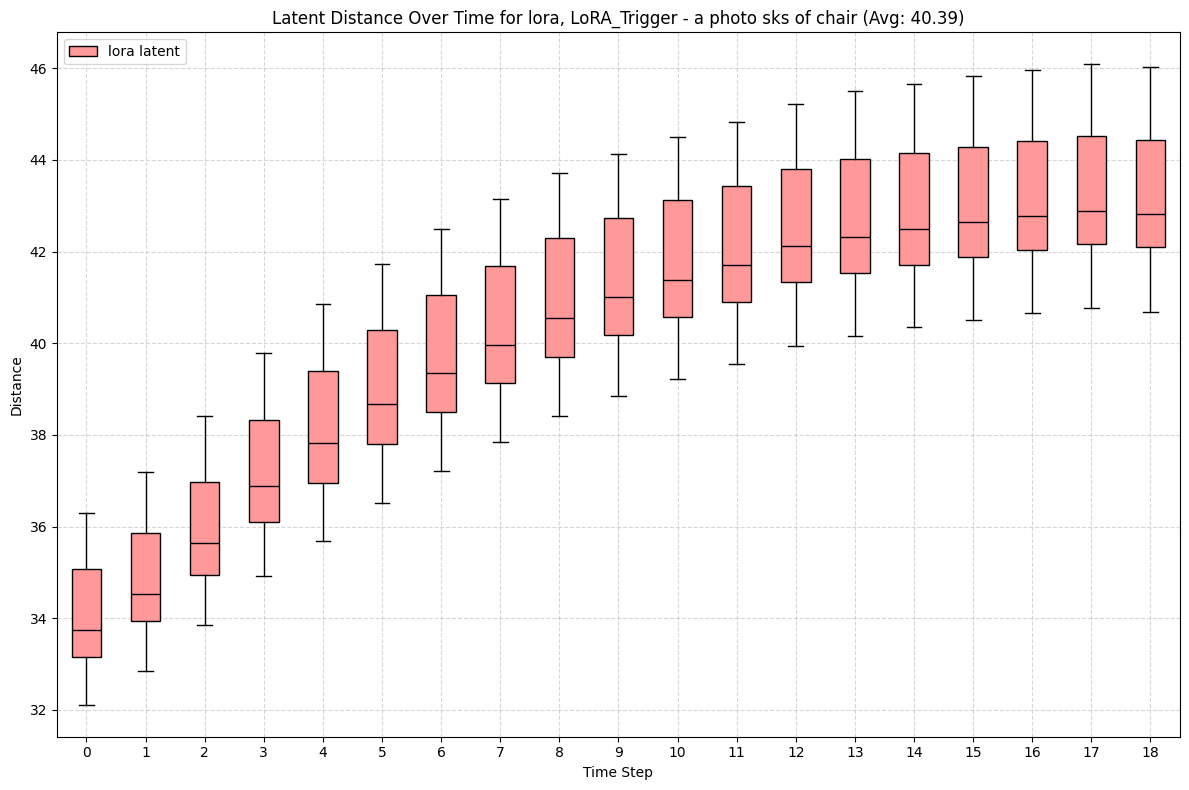

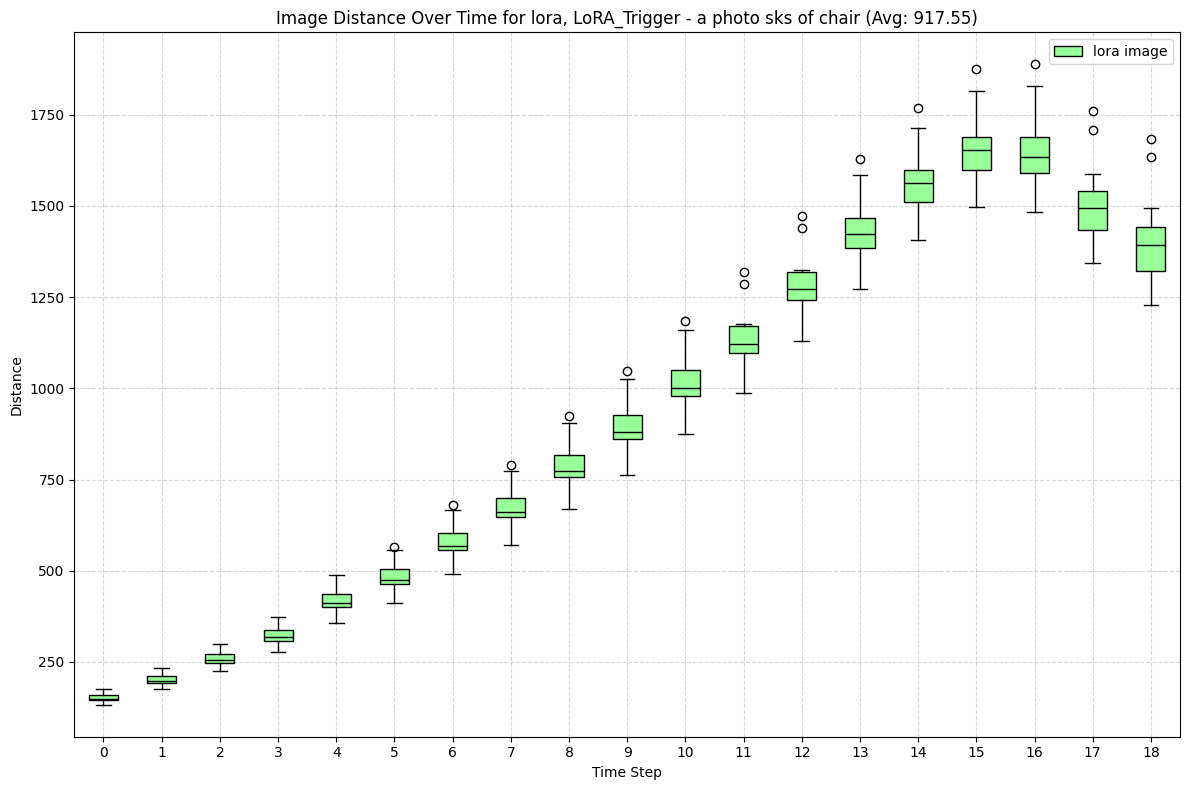

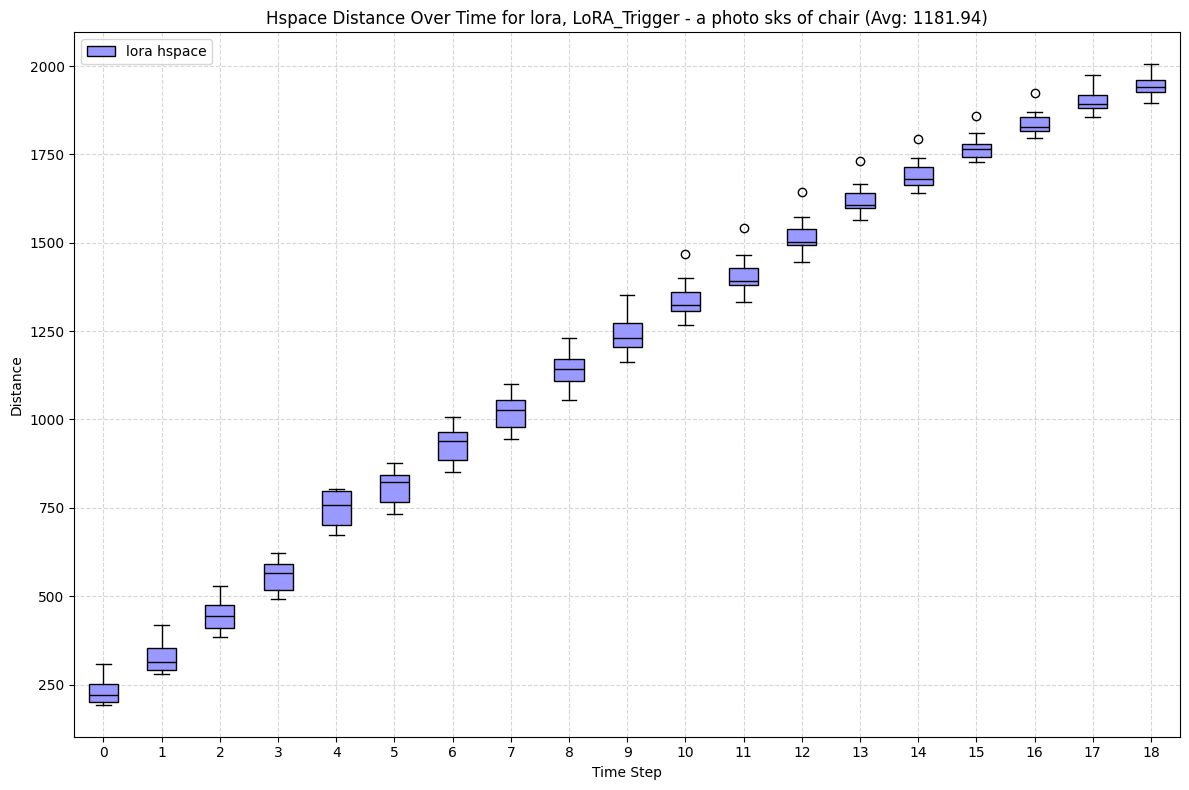

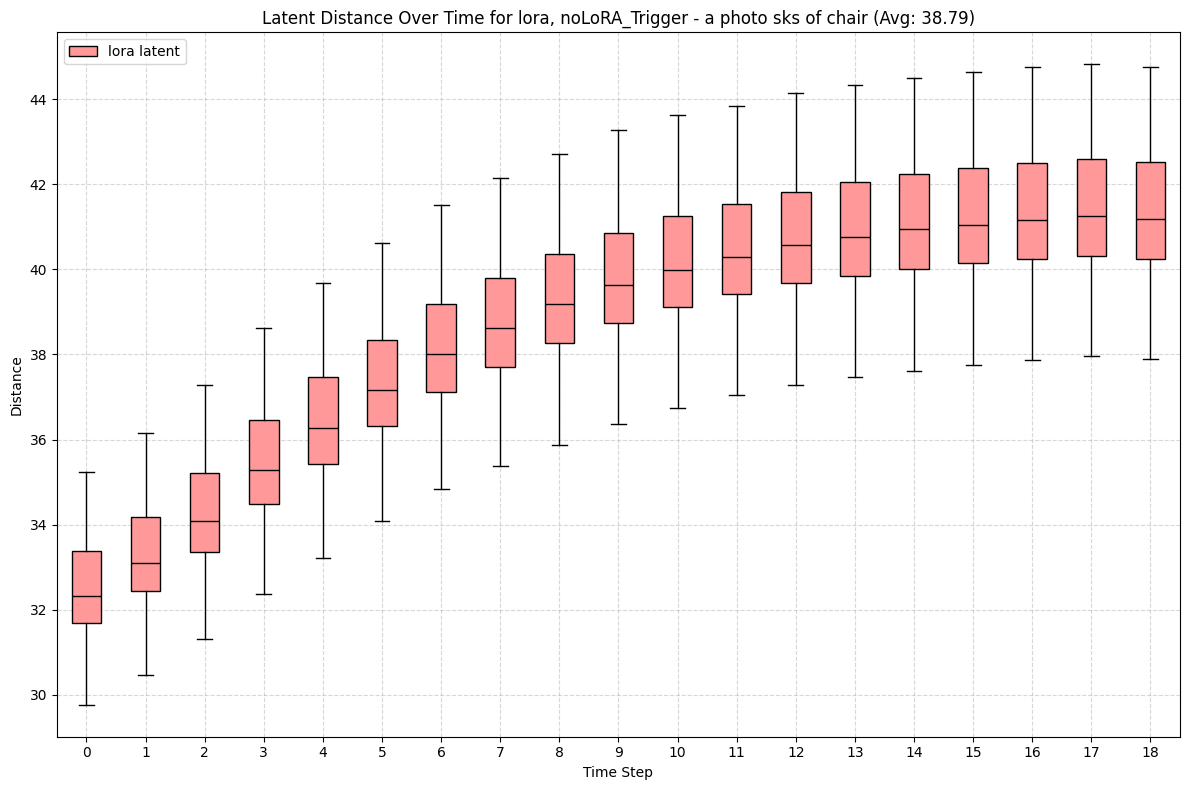

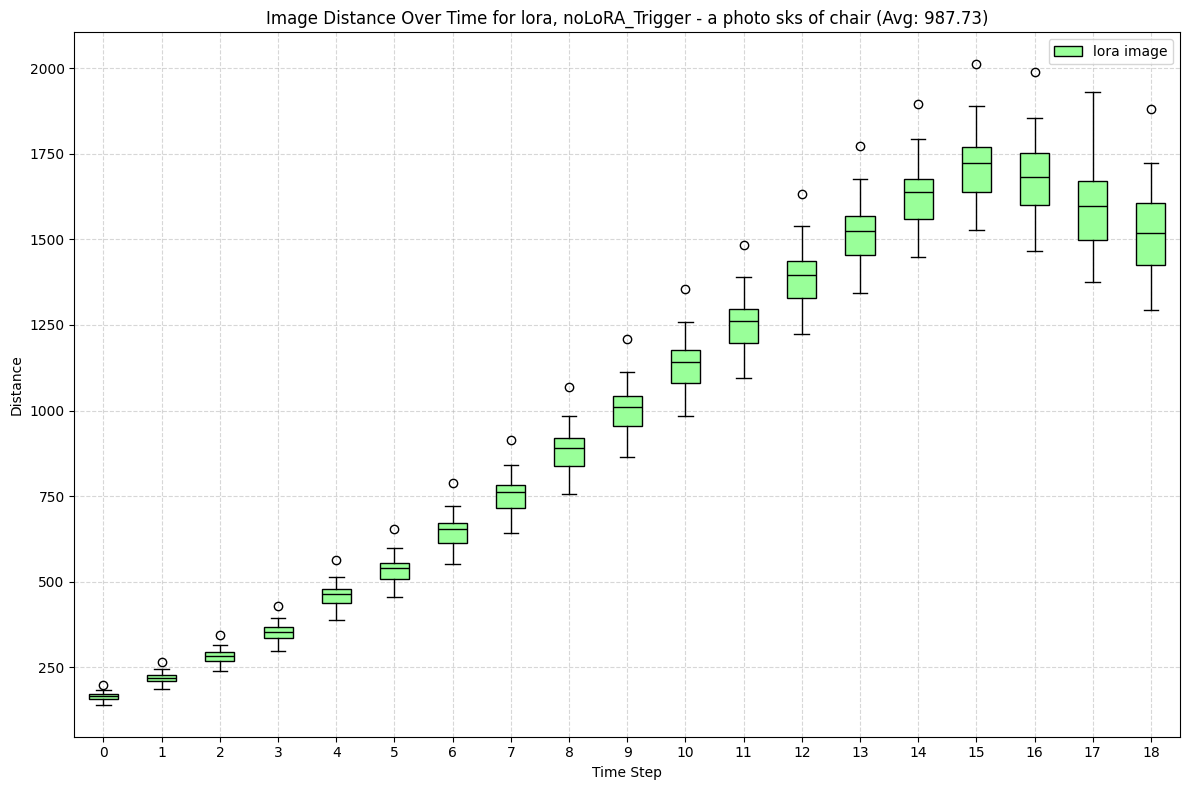

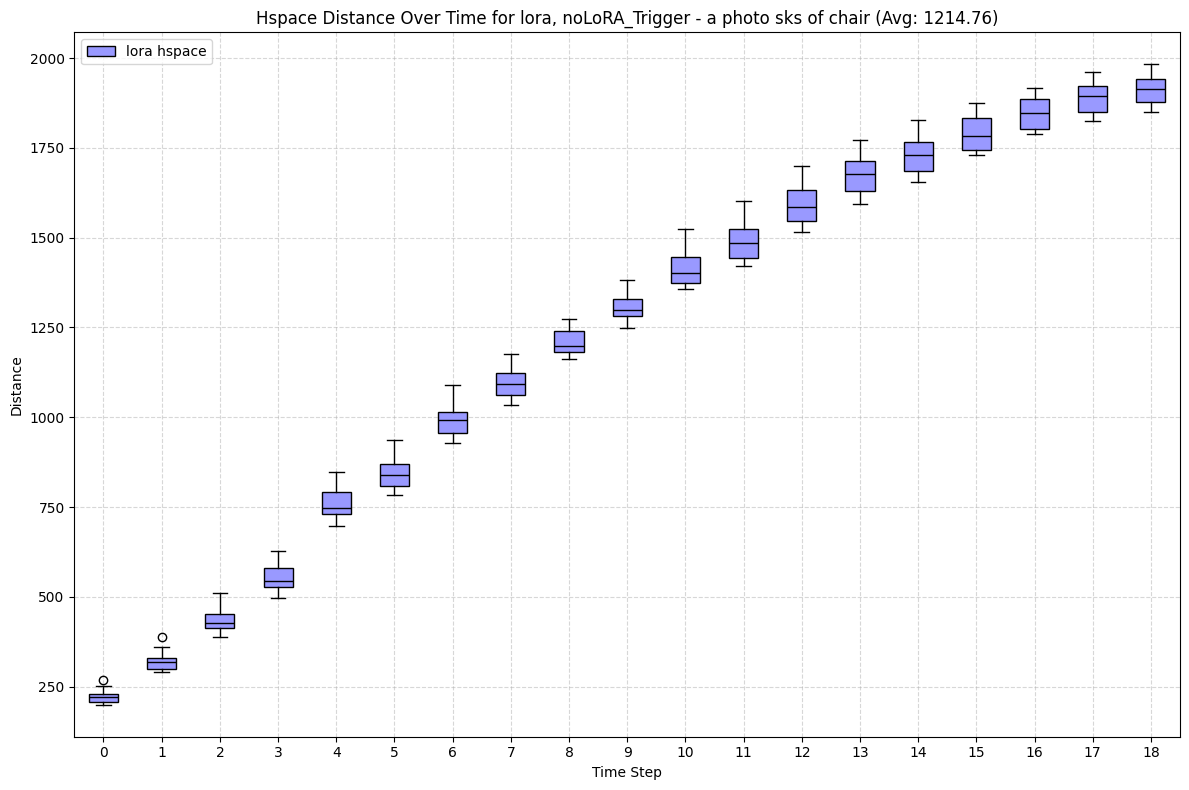

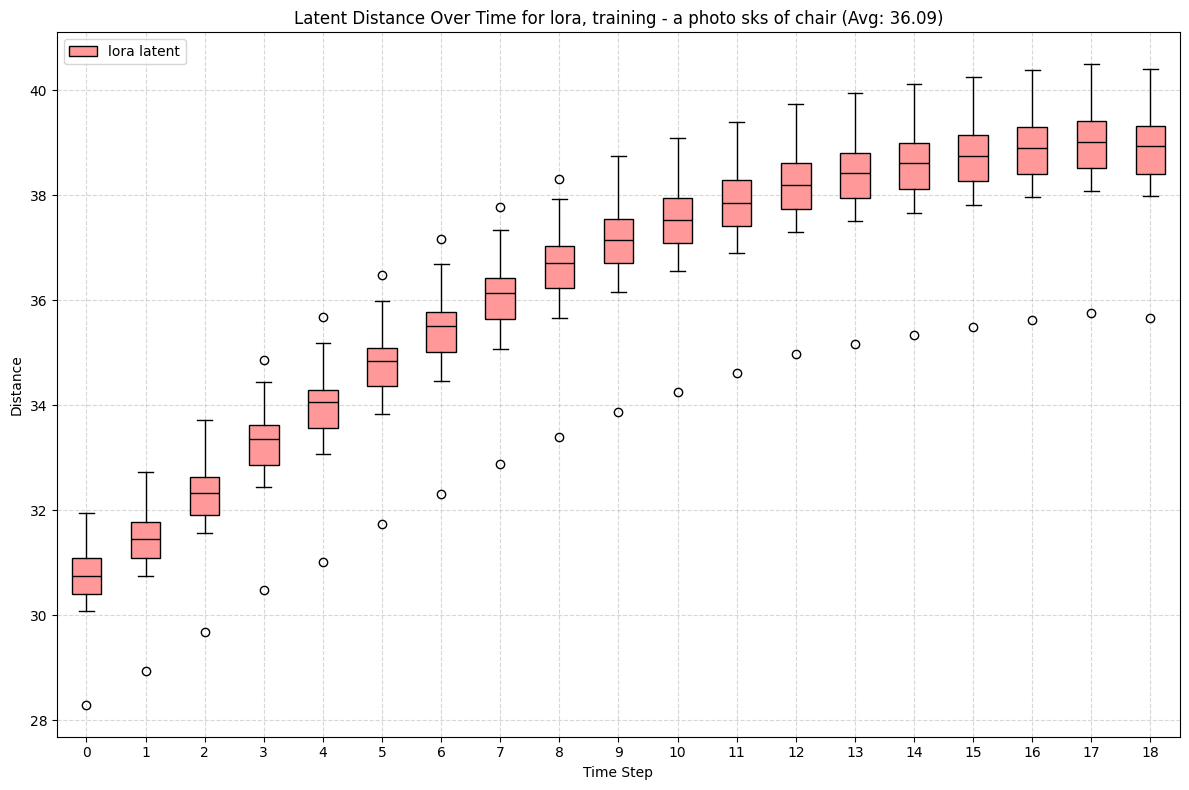

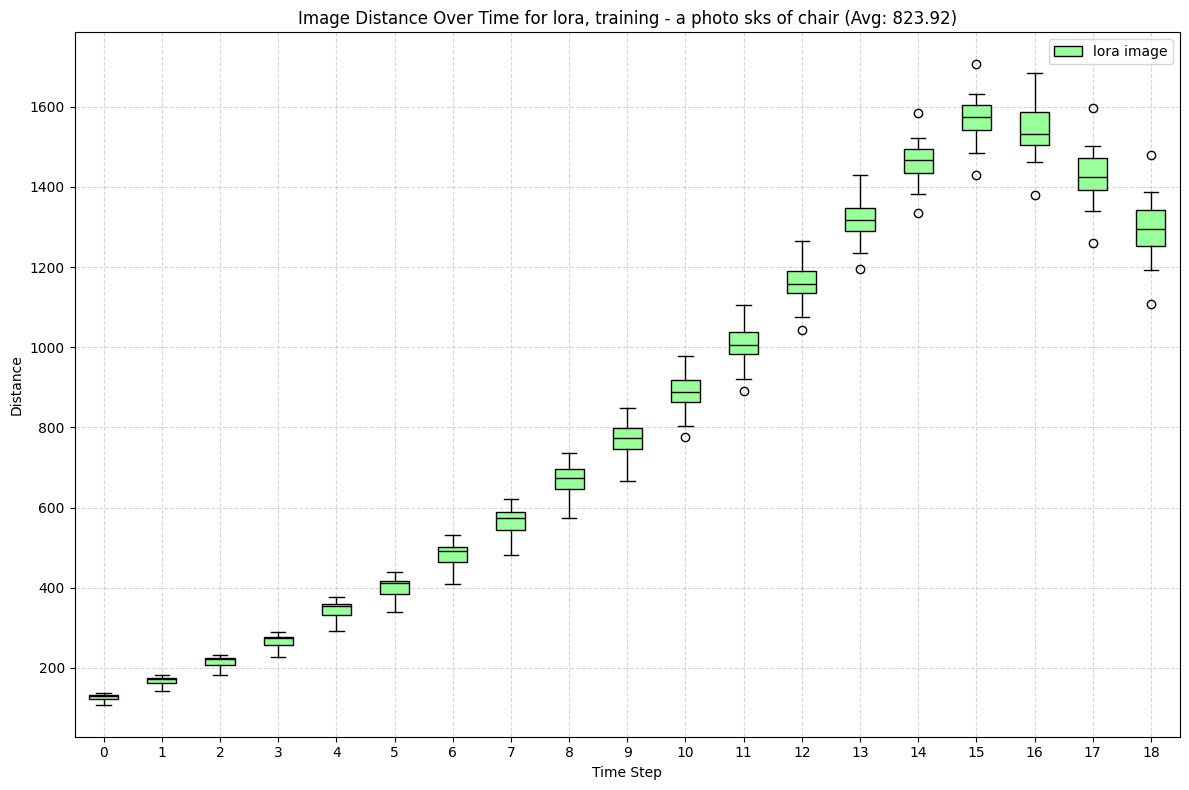

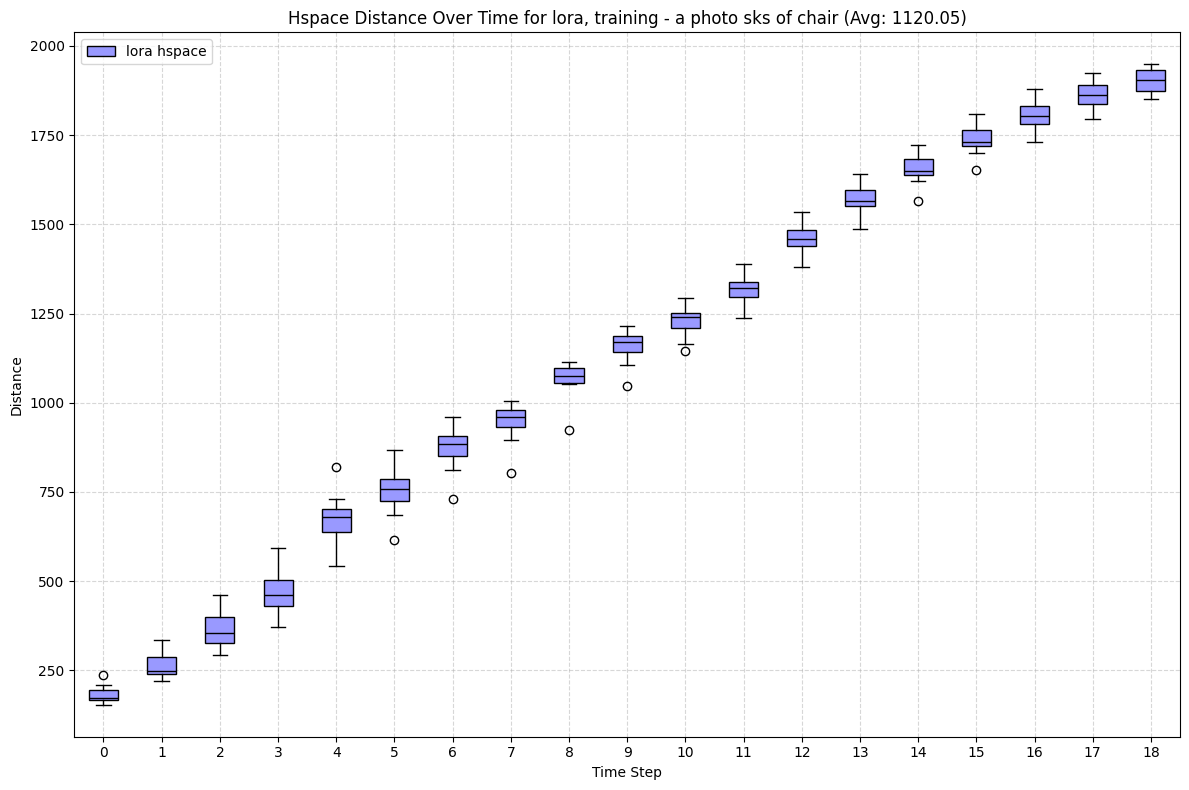

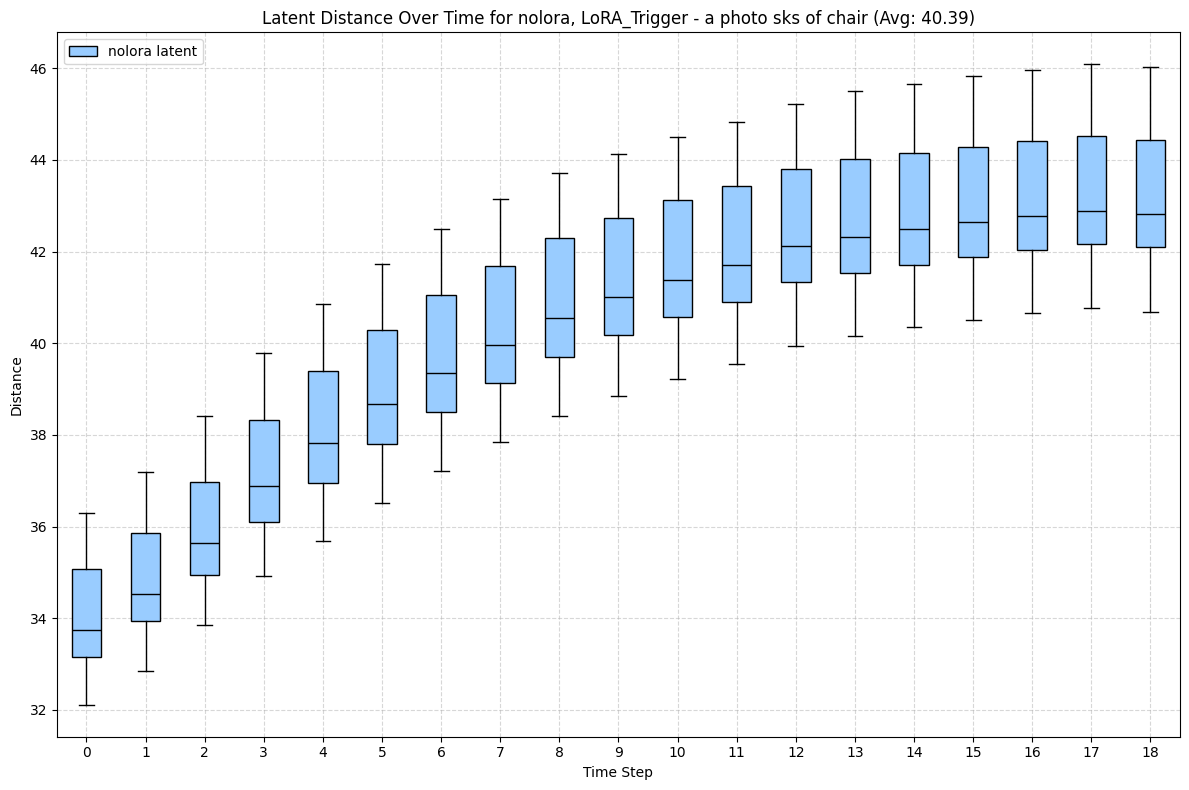

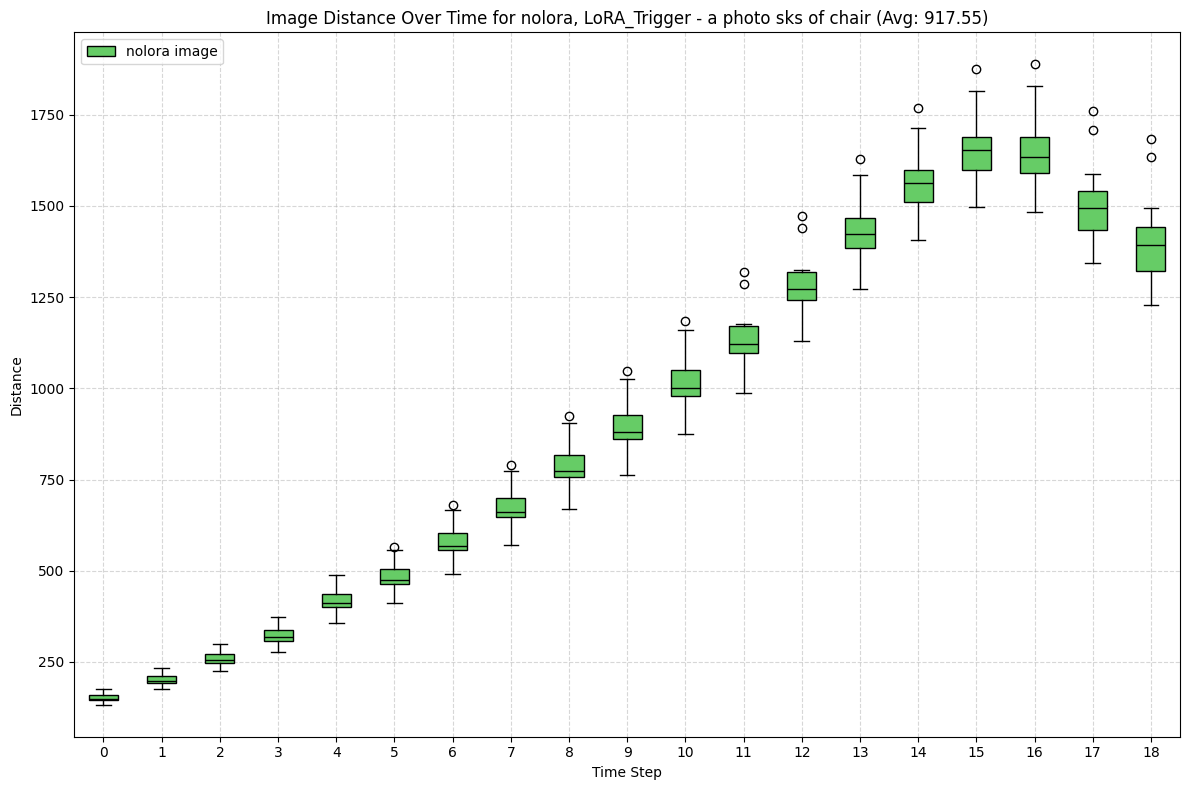

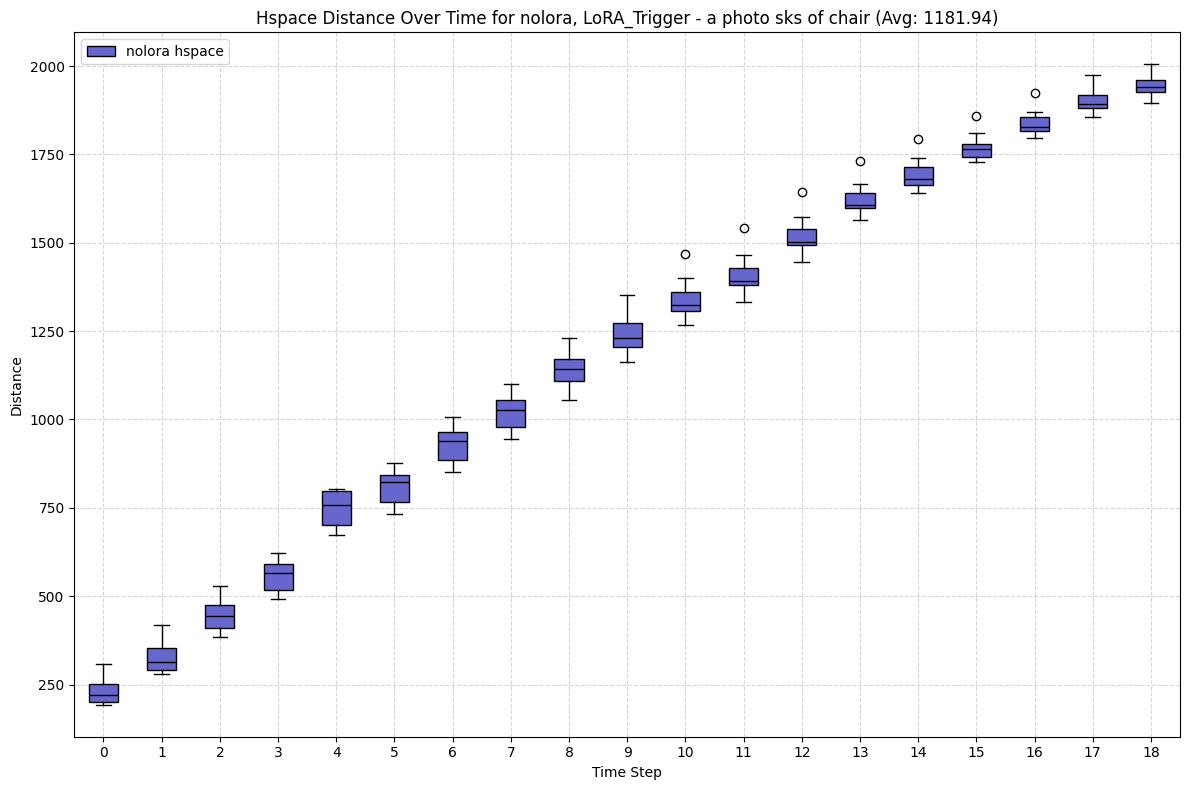

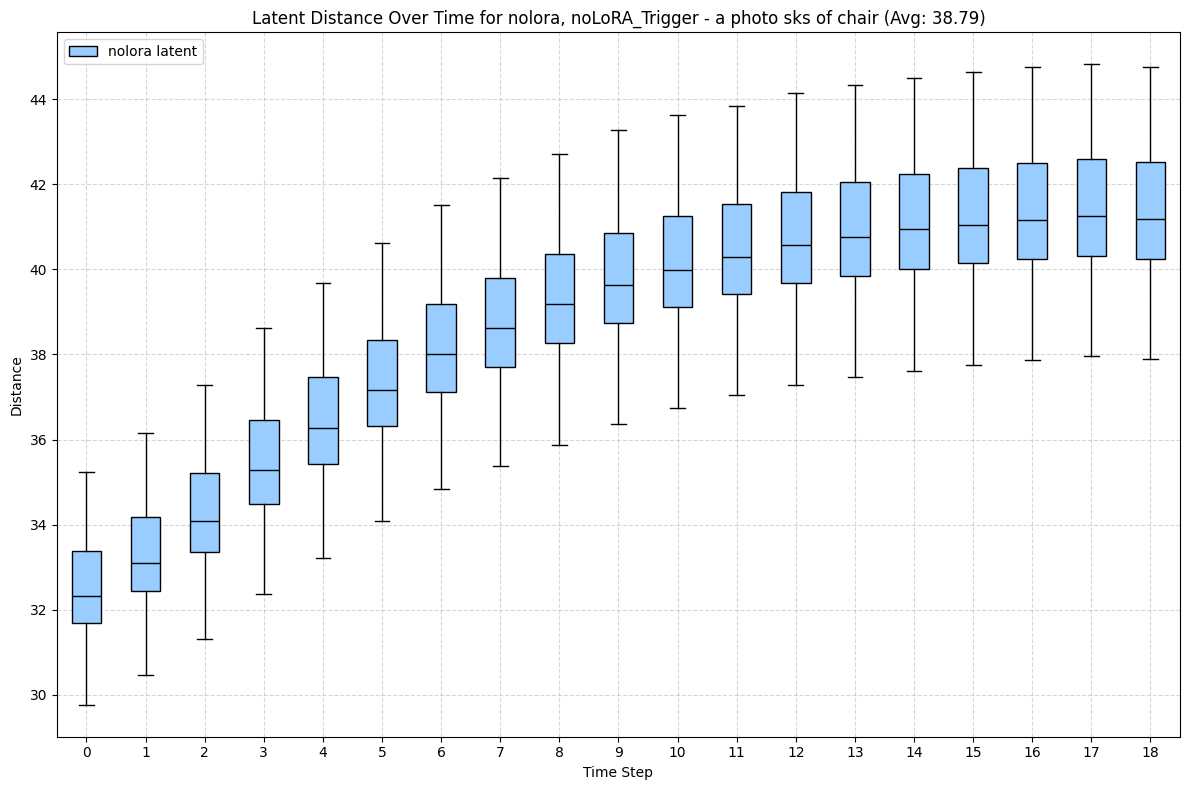

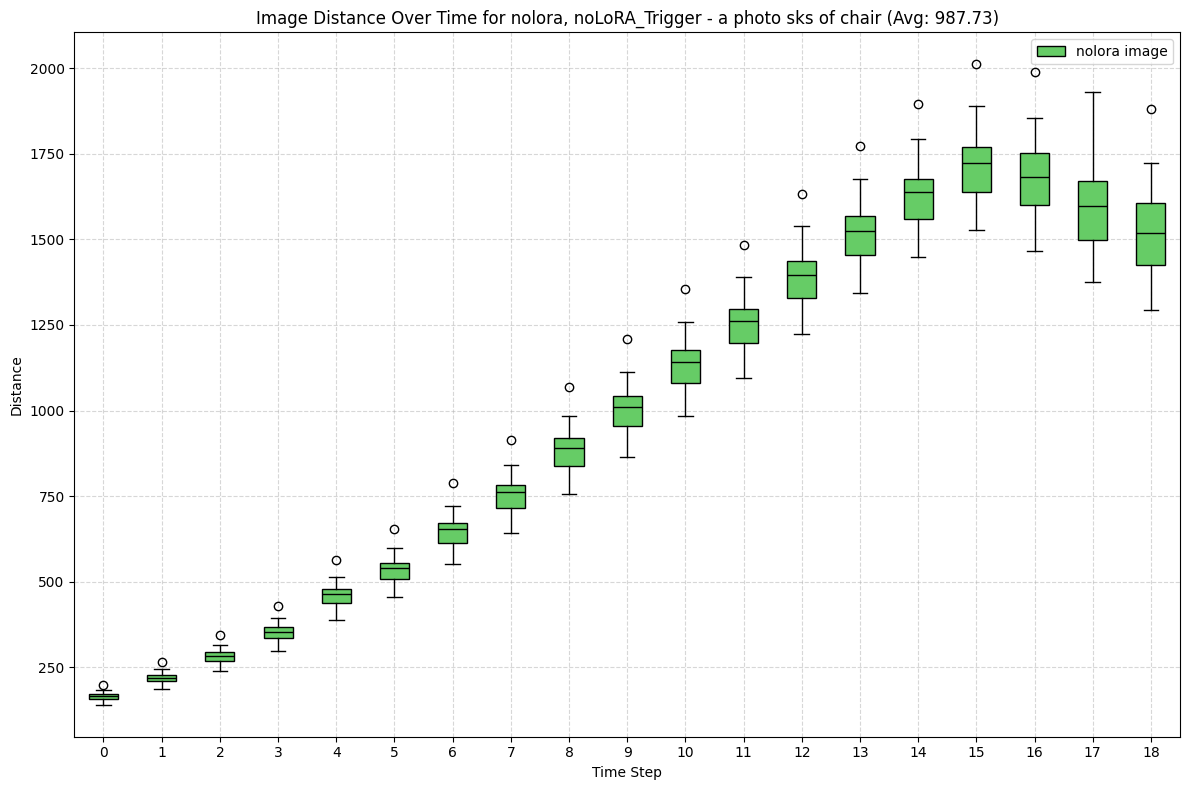

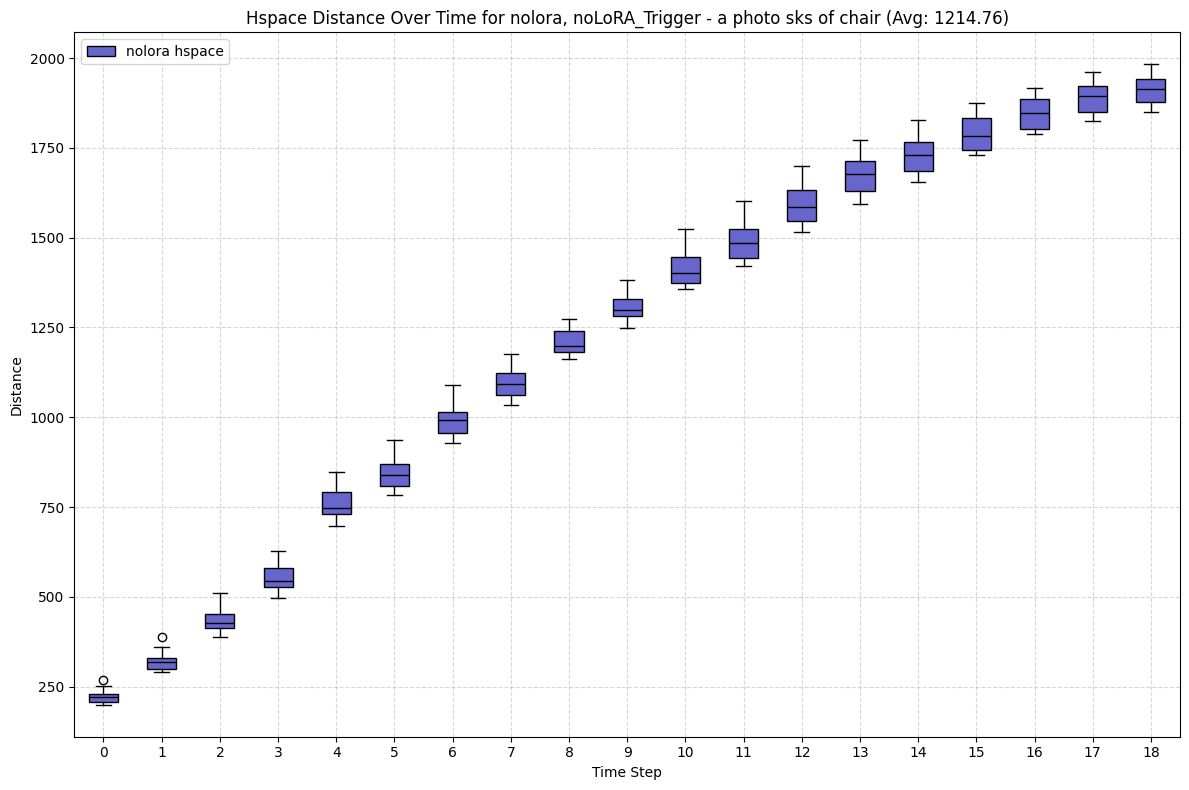

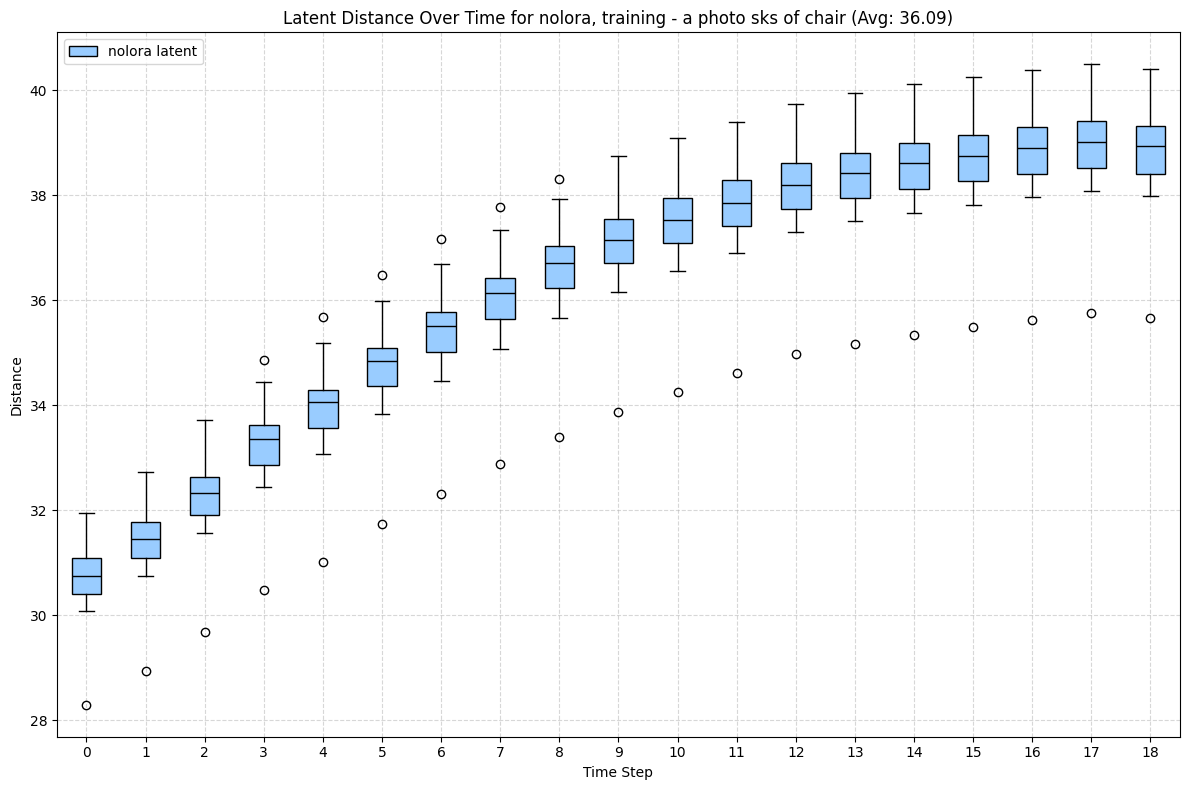

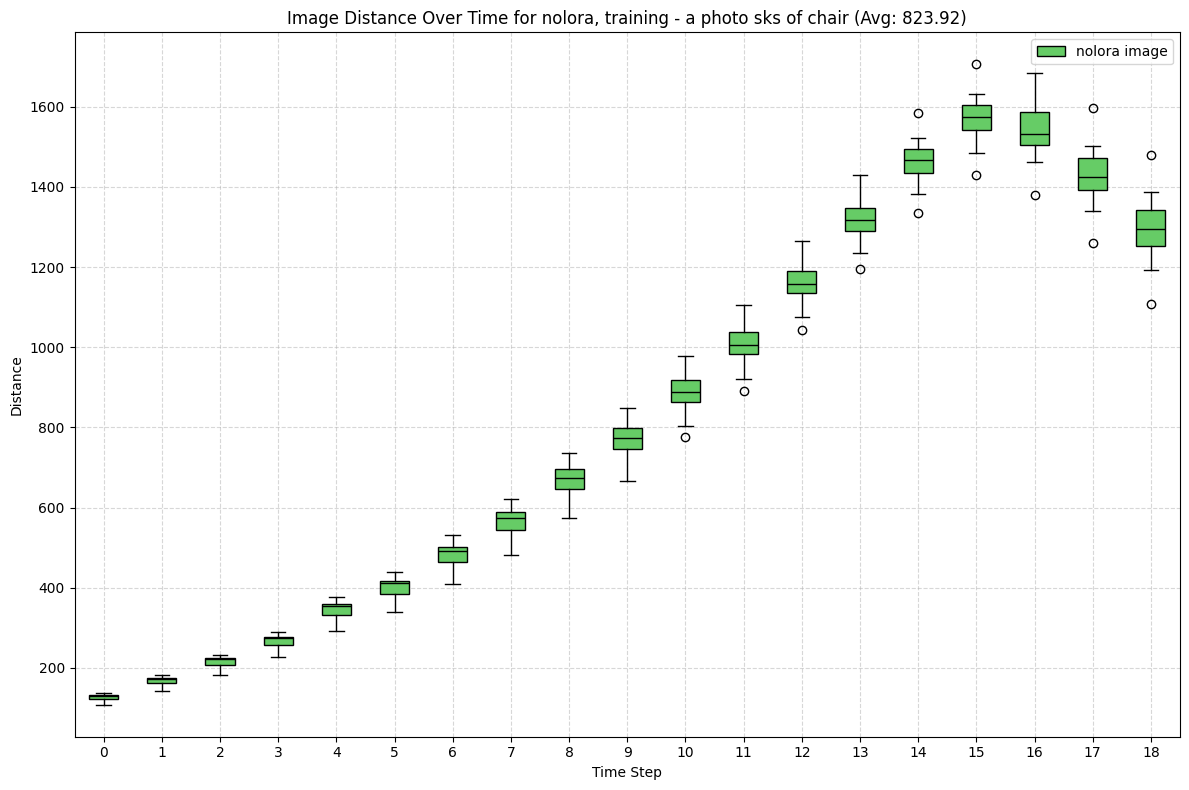

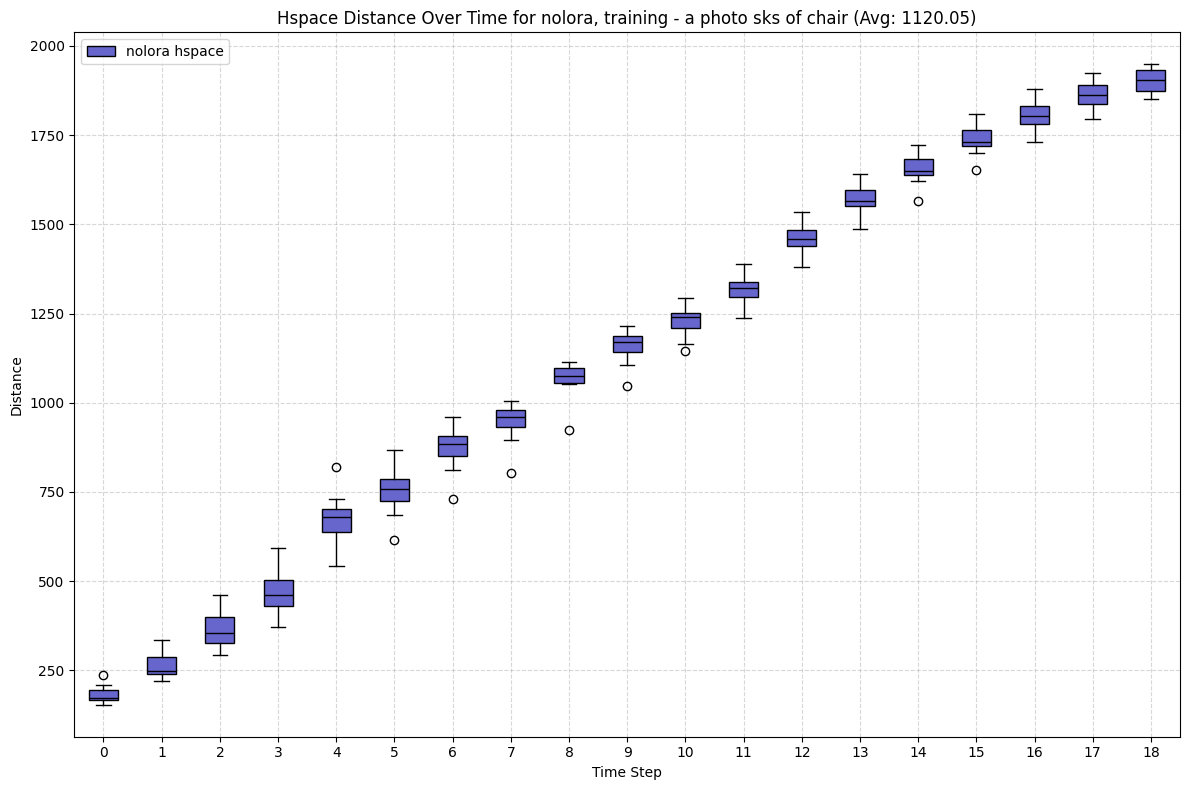

In [17]:
def plot_boxplot_time_step_as_x_axis(analysis_data):
    keys = ['latent', 'image', 'hspace']
    
    # Color mapping by base and feature type
    color_map = {
        'latent': {'lora': '#FF9999', 'nolora': '#99CCFF'},
        'image': {'lora': '#99FF99', 'nolora': '#66CC66'},
        'hspace': {'lora': '#9999FF', 'nolora': '#6666CC'}
    }
    
    for base in analysis_data:
        for prefix in analysis_data[base]:
            for prompt in analysis_data[base][prefix]:
                for key in keys:
                    try:
                        # Collect all time series data
                        all_time_series = []
                        for image_name in analysis_data[base][prefix][prompt]:
                            data = analysis_data[base][prefix][prompt][image_name].get(key, [])
                            if isinstance(data, list) and len(data) > 0:
                                all_time_series.append(data)
                    
                        if not all_time_series:
                            print(f"No data found for {base}/{prefix}/{prompt}/{key}")
                            continue
                        
                        # Determine number of time steps
                        num_times = len(all_time_series[0])
                        
                        # Reorganize data by time step
                        data_by_time = [[] for _ in range(num_times)]
                        for series in all_time_series:
                            for t, value in enumerate(series[:num_times]):
                                data_by_time[t].append(value)
                        
                        # Create plot
                        plt.figure(figsize=(12, 8))
                        box = plt.boxplot(data_by_time, patch_artist=True, 
                                        boxprops=dict(facecolor=color_map[key][base]))
                        
                        # Calculate average and set properties
                        avg_distance = np.mean([np.mean(d) for d in data_by_time if d])
                        plt.ylabel('Distance')
                        plt.xlabel('Time Step')
                        plt.title(f'{key.capitalize()} Distance Over Time for {base}, {prefix} - {prompt} (Avg: {avg_distance:.2f})')
                        plt.xticks(range(1, len(data_by_time) + 1), range(len(data_by_time)))
                        plt.legend([f"{base} {key}"])
                        
                        # Set median lines to black
                        for median in box['medians']:
                            median.set_color('black')
                        
                        plt.grid(True, linestyle='--', alpha=0.5)
                        plt.tight_layout()
                        plt.show()
                        
                    except Exception as e:
                        print(f"Error plotting {base}/{prefix}/{prompt}/{key}: {e}")

# Example usage
plot_boxplot_time_step_as_x_axis(l2_analysis_data)

In [23]:
def calculate_l2_differences_between_prefixes(experiment_data):
    """
    Calculate L2 distances between features for different prefixes:
    1. Training vs LoRA_Trigger
    2. noLoRA_Trigger vs LoRA_Trigger
    for each base model (lora and nolora)
    """
    difference_data = {}
    for base in experiment_data:
        difference_data[base] = {}
        
        # Check that all required prefixes exist
        if not all(prefix in experiment_data[base] for prefix in ["LoRA_Trigger", "training", "noLoRA_Trigger"]):
            print(f"Warning: Not all required prefixes exist for {base}. Skipping.")
            continue
        
        # Define our comparisons
        difference_data[base]["training_vs_lora"] = {}
        difference_data[base]["nolora_vs_lora"] = {}
        
        # Find common prompts across all prefixes
        lora_prompts = set(experiment_data[base]["LoRA_Trigger"].keys())
        training_prompts = set(experiment_data[base]["training"].keys())
        nolora_prompts = set(experiment_data[base]["noLoRA_Trigger"].keys())
        
        common_prompts = lora_prompts.intersection(training_prompts, nolora_prompts)
        
        for prompt in common_prompts:
            difference_data[base]["training_vs_lora"][prompt] = {}
            difference_data[base]["nolora_vs_lora"][prompt] = {}
            
            # Calculate L2 distances for each key and time step
            for key in ["latent", "image", "hspace"]:
                # Get reference images for each prefix
                lora_images = list(experiment_data[base]["LoRA_Trigger"][prompt].keys())
                training_images = list(experiment_data[base]["training"][prompt].keys())
                nolora_images = list(experiment_data[base]["noLoRA_Trigger"][prompt].keys())
                
                # Skip if no images available
                if not lora_images or not training_images or not nolora_images:
                    continue
                
                # Get first image as reference
                lora_ref = lora_images[0]
                training_ref = training_images[0]
                nolora_ref = nolora_images[0]
                
                # Get features
                lora_features = experiment_data[base]["LoRA_Trigger"][prompt][lora_ref][key]
                training_features = experiment_data[base]["training"][prompt][training_ref][key]
                nolora_features = experiment_data[base]["noLoRA_Trigger"][prompt][nolora_ref][key]
                
                # Ensure all features have the same length by using the minimum length
                min_length = min(len(lora_features), len(training_features), len(nolora_features))
                
                # Calculate L2 distances
                training_vs_lora = [euclidean(training_features[i], lora_features[i]) for i in range(min_length)]
                nolora_vs_lora = [euclidean(nolora_features[i], lora_features[i]) for i in range(min_length)]
                
                difference_data[base]["training_vs_lora"][prompt][key] = training_vs_lora
                difference_data[base]["nolora_vs_lora"][prompt][key] = nolora_vs_lora
                
    return difference_data


In [24]:

def plot_l2_difference_data(difference_data):
    """
    Plot the L2 distance data with time steps on x-axis and distance values on y-axis
    """
    # Colors for each difference type and base
    colors = {
        'lora': {
            'training_vs_lora': '#FF6B6B',  # Coral Red
            'nolora_vs_lora': '#FF8787',    # Light Coral
        },
        'nolora': {
            'training_vs_lora': '#6BCBFF',  # Sky Blue
            'nolora_vs_lora': '#87D4FF',    # Light Sky Blue
        }
    }
    
    for base in difference_data:
        for diff_type in difference_data[base]:
            for prompt in difference_data[base][diff_type]:
                # Create a figure for each key (latent, image, hspace)
                plt.figure(figsize=(14, 10))
                
                for key in ["latent", "image", "hspace"]:
                    if key not in difference_data[base][diff_type][prompt]:
                        continue
                        
                    data = difference_data[base][diff_type][prompt][key]
                    
                    # Check if there's data to plot
                    if not data:
                        continue
                    
                    # Plot the difference series
                    plt.plot(range(len(data)), data, 
                             label=f"{key}", 
                             linewidth=2, 
                             marker='o', 
                             markersize=5)
                
                # Format plot
                plt.title(f"{diff_type.replace('_', ' ').title()} for {base} ({prompt})")
                plt.xlabel("Time Step")
                plt.ylabel("L2 Distance")
                plt.grid(True, linestyle='--', alpha=0.7)
                plt.legend()
                plt.tight_layout()
                plt.show()
                
                # Create separate plots for each key
                for key in ["latent", "image", "hspace"]:
                    if key not in difference_data[base][diff_type][prompt]:
                        continue
                        
                    data = difference_data[base][diff_type][prompt][key]
                    
                    # Check if there's data to plot
                    if not data:
                        continue
                    
                    plt.figure(figsize=(12, 8))
                    plt.plot(range(len(data)), data, 
                             color=colors[base][diff_type], 
                             linewidth=2.5, 
                             marker='o', 
                             markersize=5)
                    
                    plt.title(f"{diff_type.replace('_', ' ').title()} for {base} - {key} ({prompt})")
                    plt.xlabel("Time Step")
                    plt.ylabel(f"L2 Distance in {key}")
                    
                    # Add grid
                    plt.grid(True, linestyle='--', alpha=0.7)
                    
                    # Add textbox with statistics in the corner
                    mean_diff = np.mean(data)
                    std_diff = np.std(data)
                    min_diff = np.min(data)
                    max_diff = np.max(data)
                    
                    stats_text = (
                        f"Mean: {mean_diff:.4f}\n"
                        f"Std: {std_diff:.4f}\n"
                        f"Min: {min_diff:.4f}\n"
                        f"Max: {max_diff:.4f}"
                    )
                    
                    plt.text(0.02, 0.98, stats_text, 
                             transform=plt.gca().transAxes,
                             verticalalignment='top',
                             horizontalalignment='left',
                             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                    
                    plt.tight_layout()
                    plt.show()
                    
                    # Print statistics
                    print(f"Statistics for {base} - {diff_type} - {key} ({prompt}):")
                    print(f"  Mean L2 distance: {mean_diff:.4f}")
                    print(f"  Std deviation: {std_diff:.4f}")
                    print(f"  Min: {min_diff:.4f}, Max: {max_diff:.4f}")
                    print()


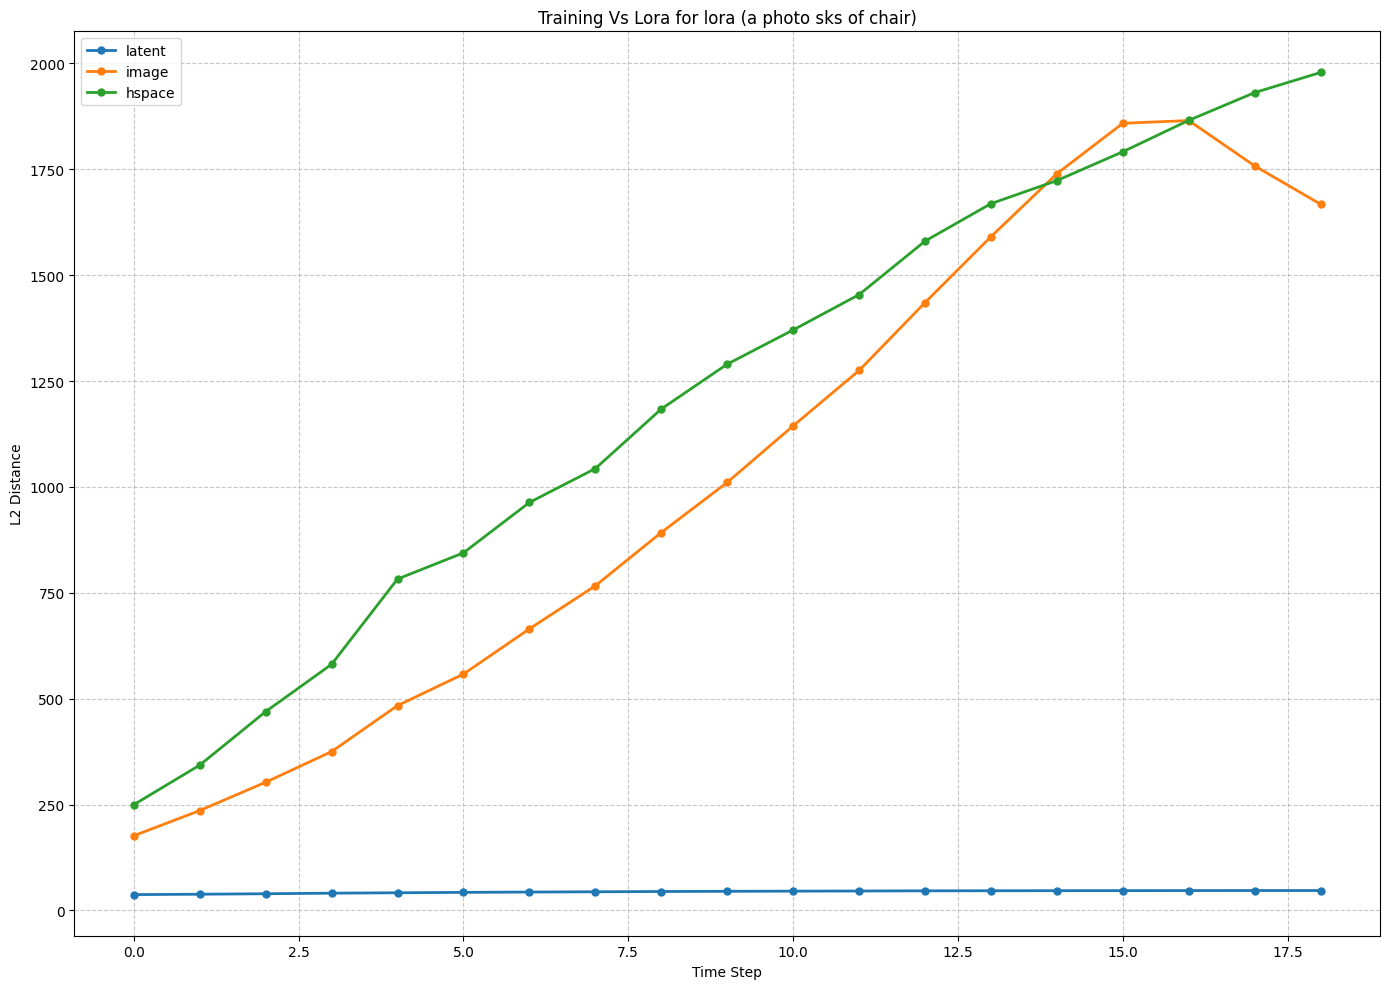

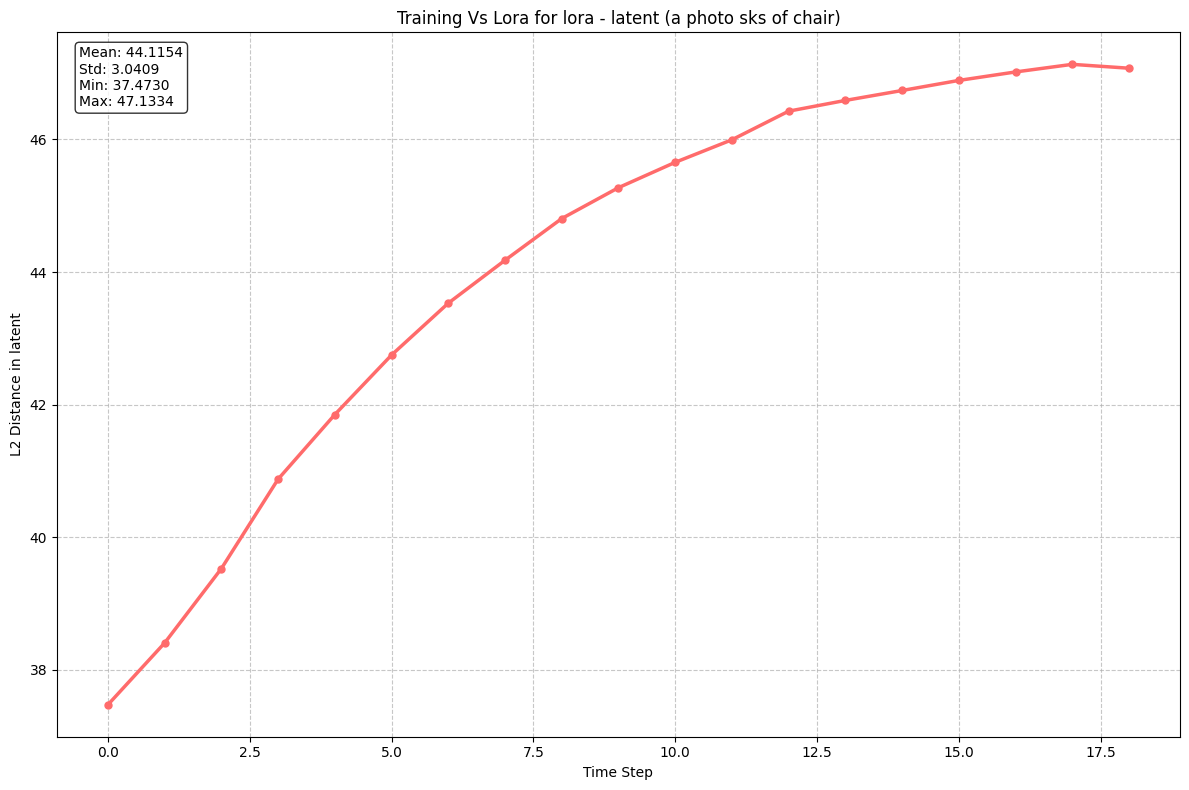

Statistics for lora - training_vs_lora - latent (a photo sks of chair):
  Mean L2 distance: 44.1154
  Std deviation: 3.0409
  Min: 37.4730, Max: 47.1334



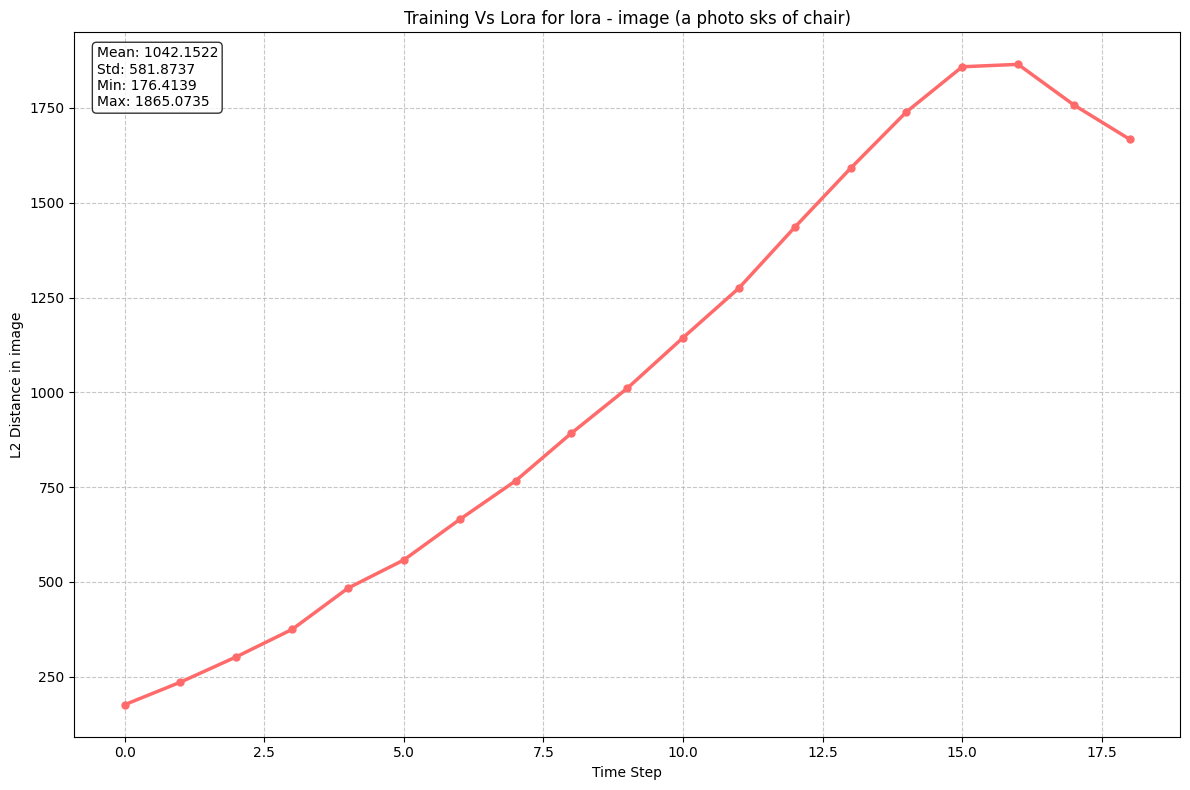

Statistics for lora - training_vs_lora - image (a photo sks of chair):
  Mean L2 distance: 1042.1522
  Std deviation: 581.8737
  Min: 176.4139, Max: 1865.0735



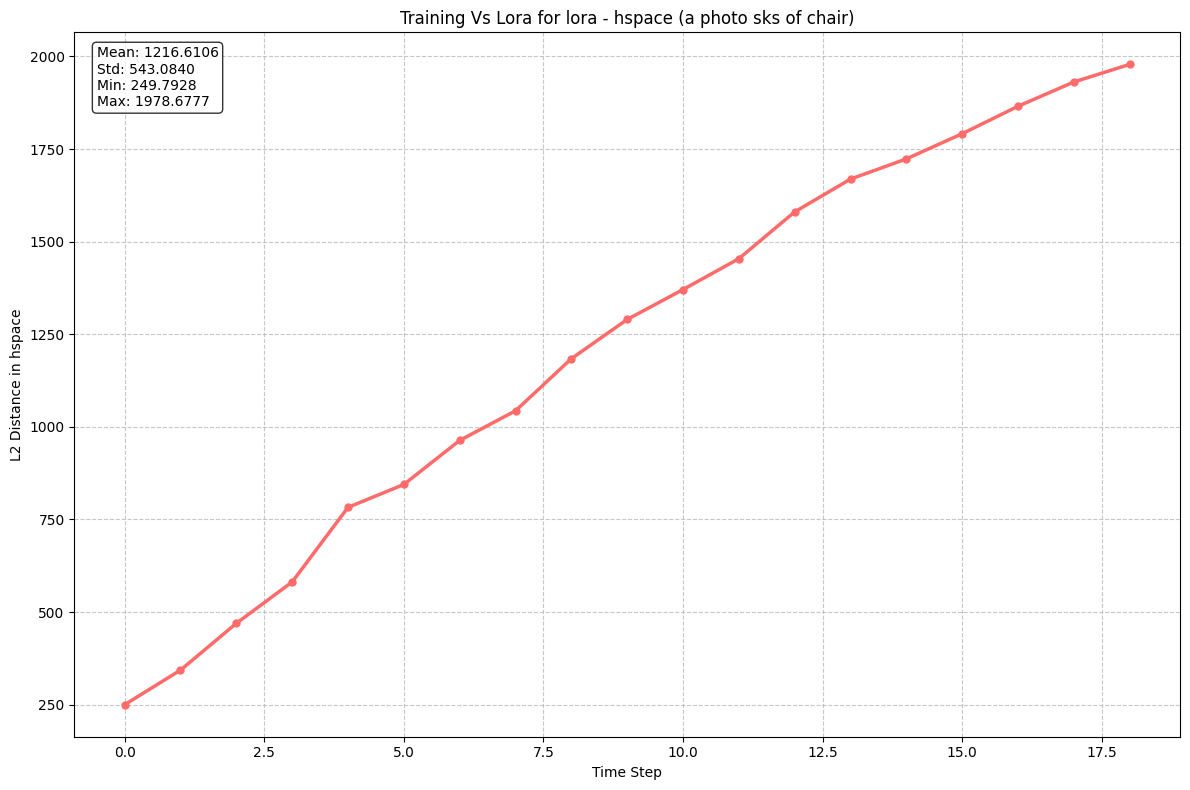

Statistics for lora - training_vs_lora - hspace (a photo sks of chair):
  Mean L2 distance: 1216.6106
  Std deviation: 543.0840
  Min: 249.7928, Max: 1978.6777



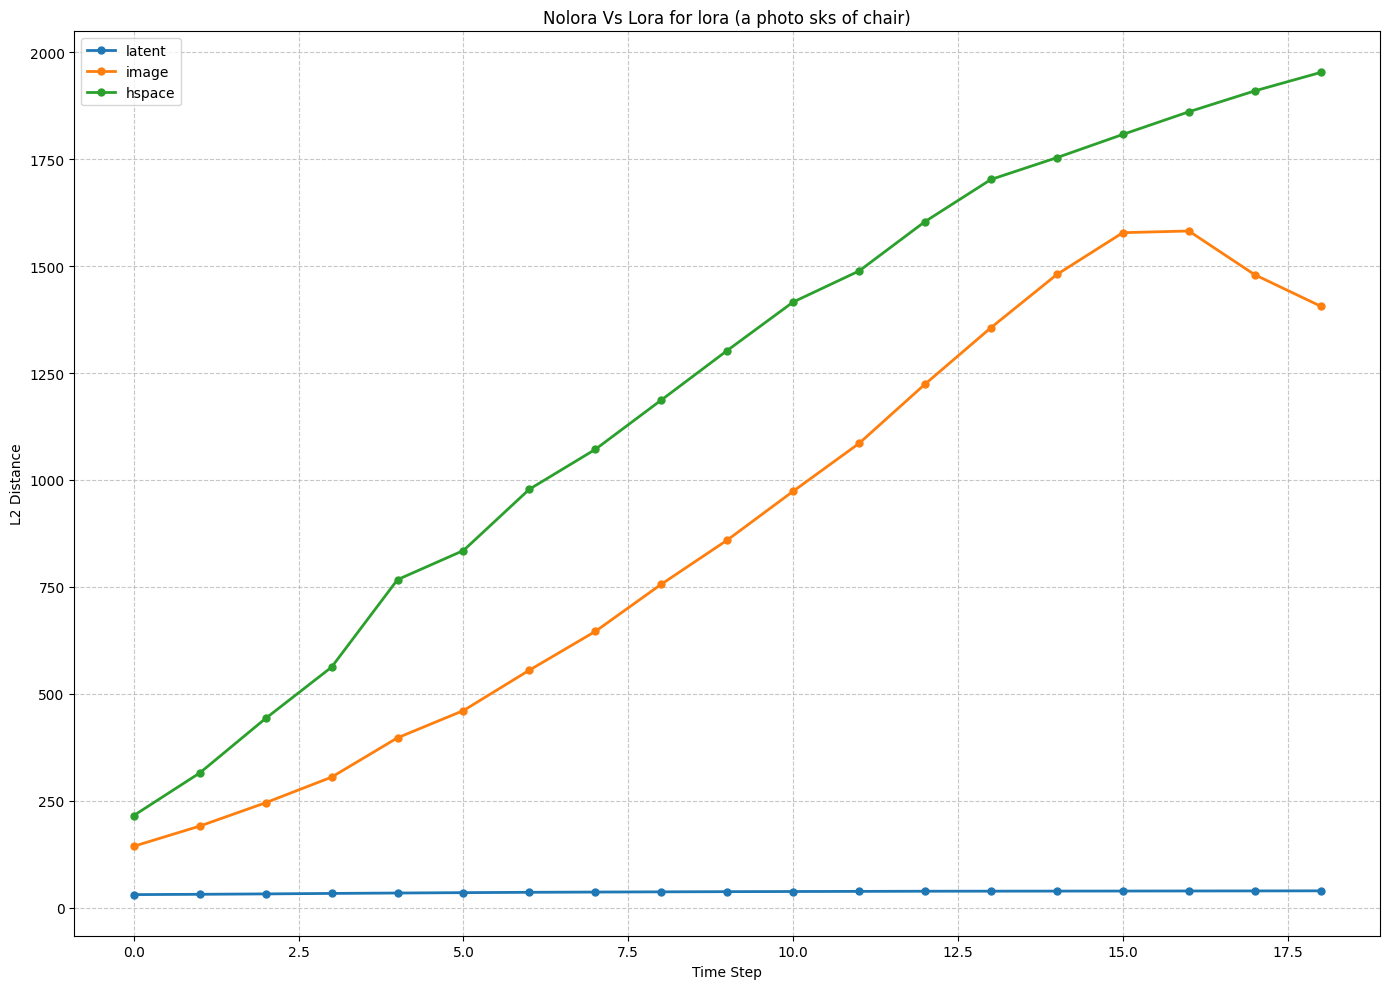

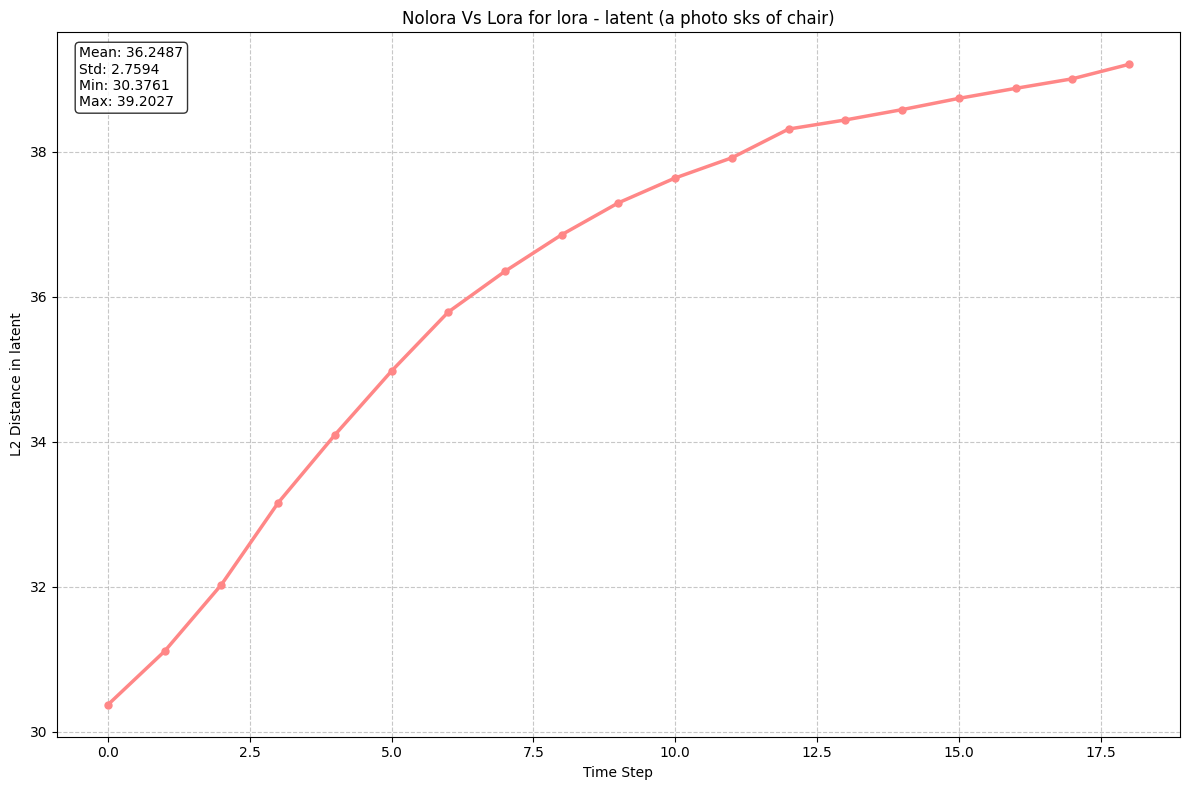

Statistics for lora - nolora_vs_lora - latent (a photo sks of chair):
  Mean L2 distance: 36.2487
  Std deviation: 2.7594
  Min: 30.3761, Max: 39.2027



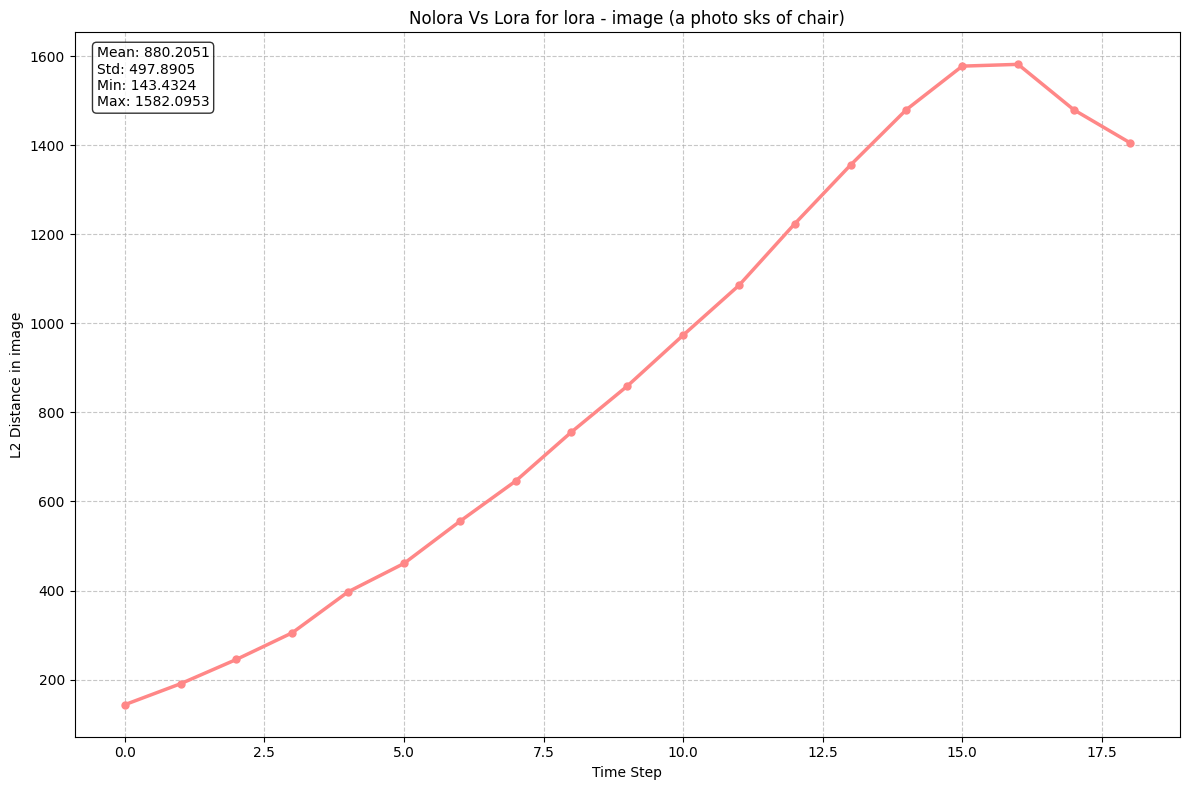

Statistics for lora - nolora_vs_lora - image (a photo sks of chair):
  Mean L2 distance: 880.2051
  Std deviation: 497.8905
  Min: 143.4324, Max: 1582.0953



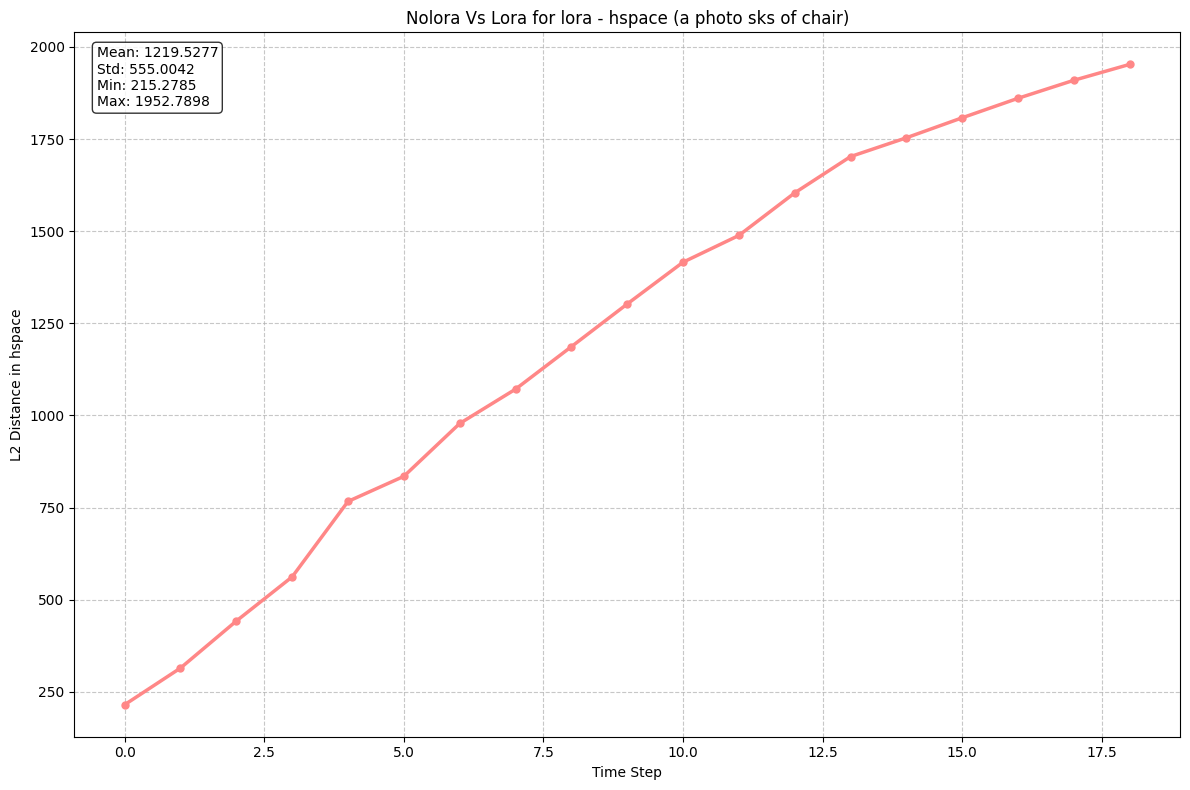

Statistics for lora - nolora_vs_lora - hspace (a photo sks of chair):
  Mean L2 distance: 1219.5277
  Std deviation: 555.0042
  Min: 215.2785, Max: 1952.7898



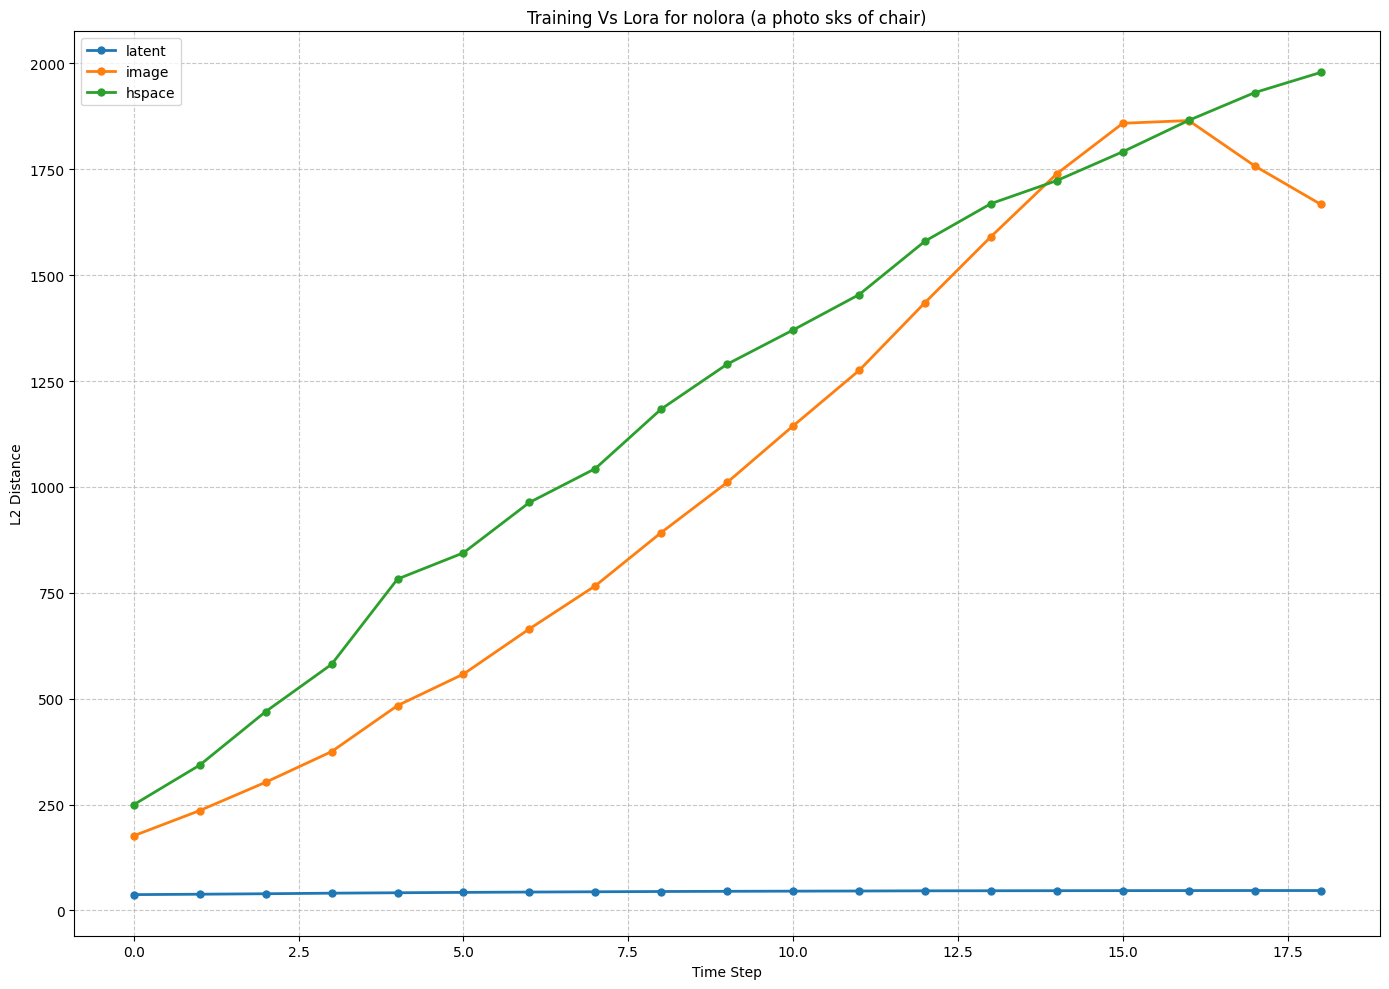

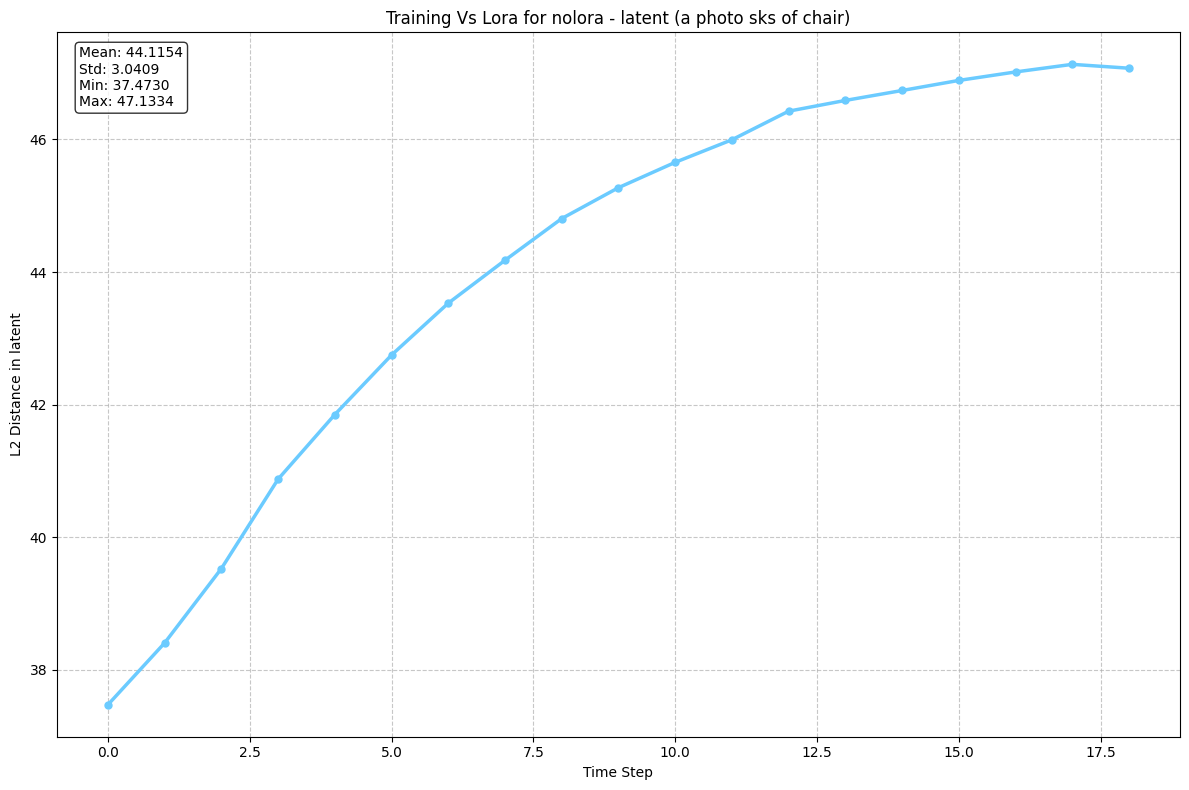

Statistics for nolora - training_vs_lora - latent (a photo sks of chair):
  Mean L2 distance: 44.1154
  Std deviation: 3.0409
  Min: 37.4730, Max: 47.1334



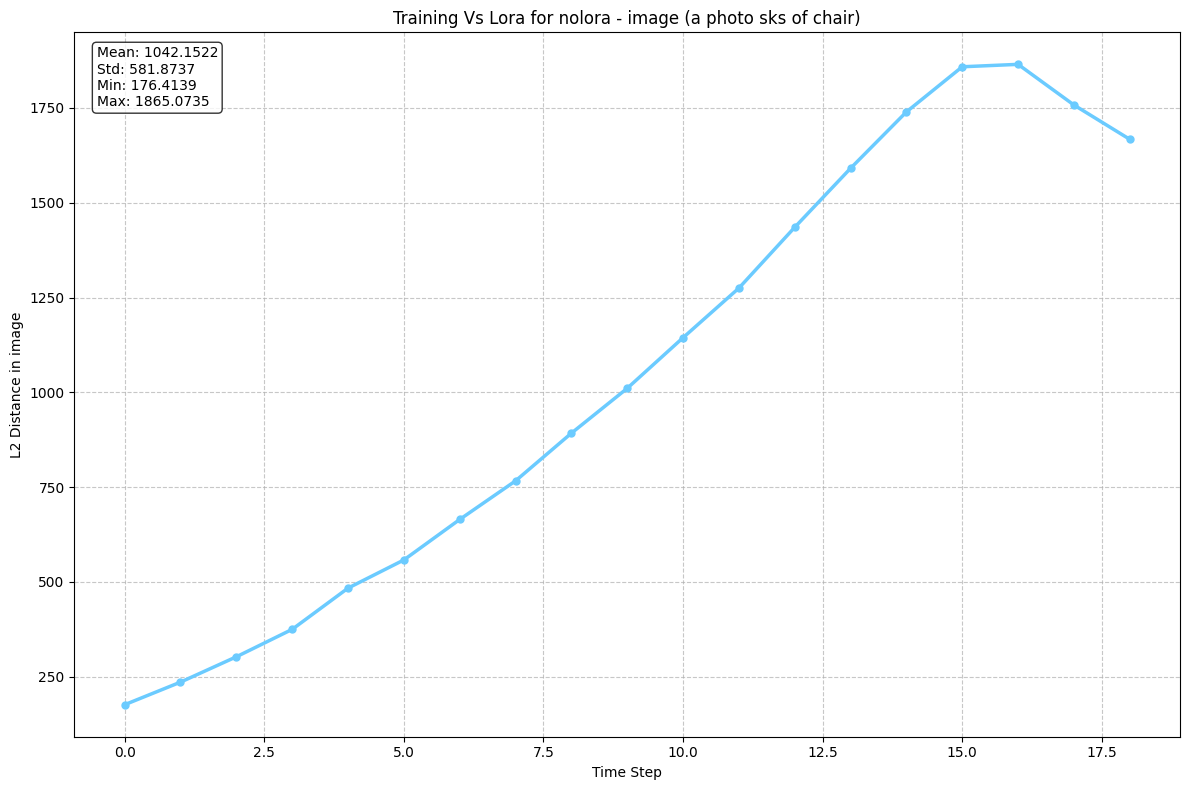

Statistics for nolora - training_vs_lora - image (a photo sks of chair):
  Mean L2 distance: 1042.1522
  Std deviation: 581.8737
  Min: 176.4139, Max: 1865.0735



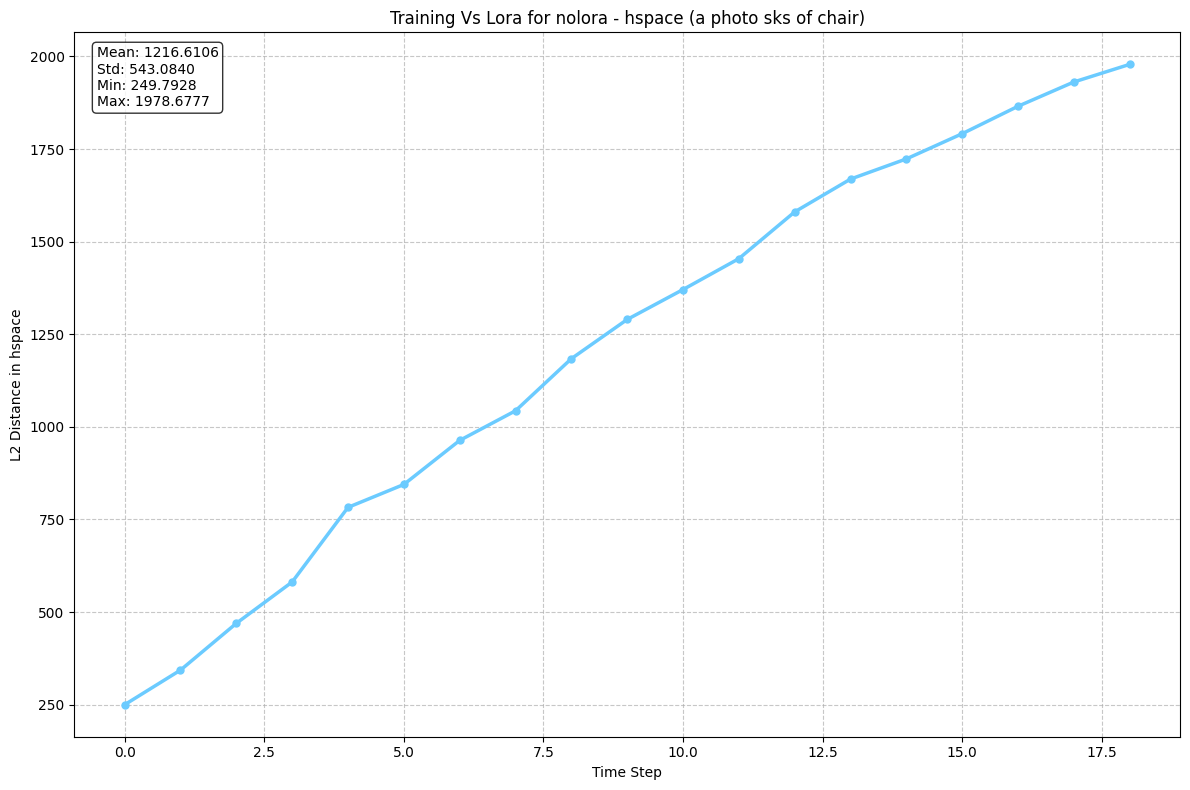

Statistics for nolora - training_vs_lora - hspace (a photo sks of chair):
  Mean L2 distance: 1216.6106
  Std deviation: 543.0840
  Min: 249.7928, Max: 1978.6777



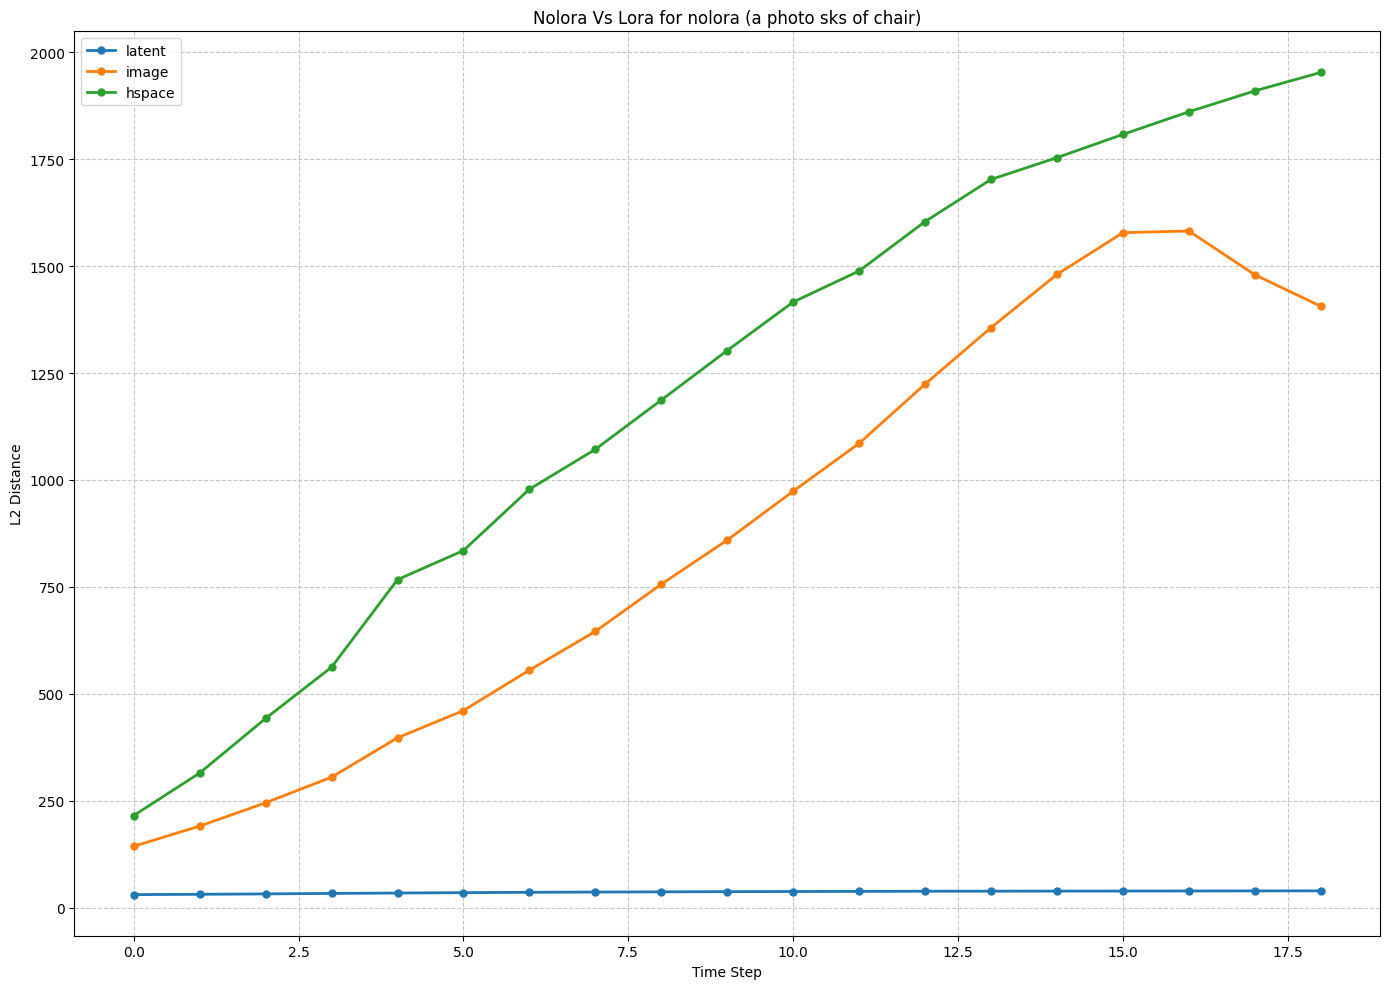

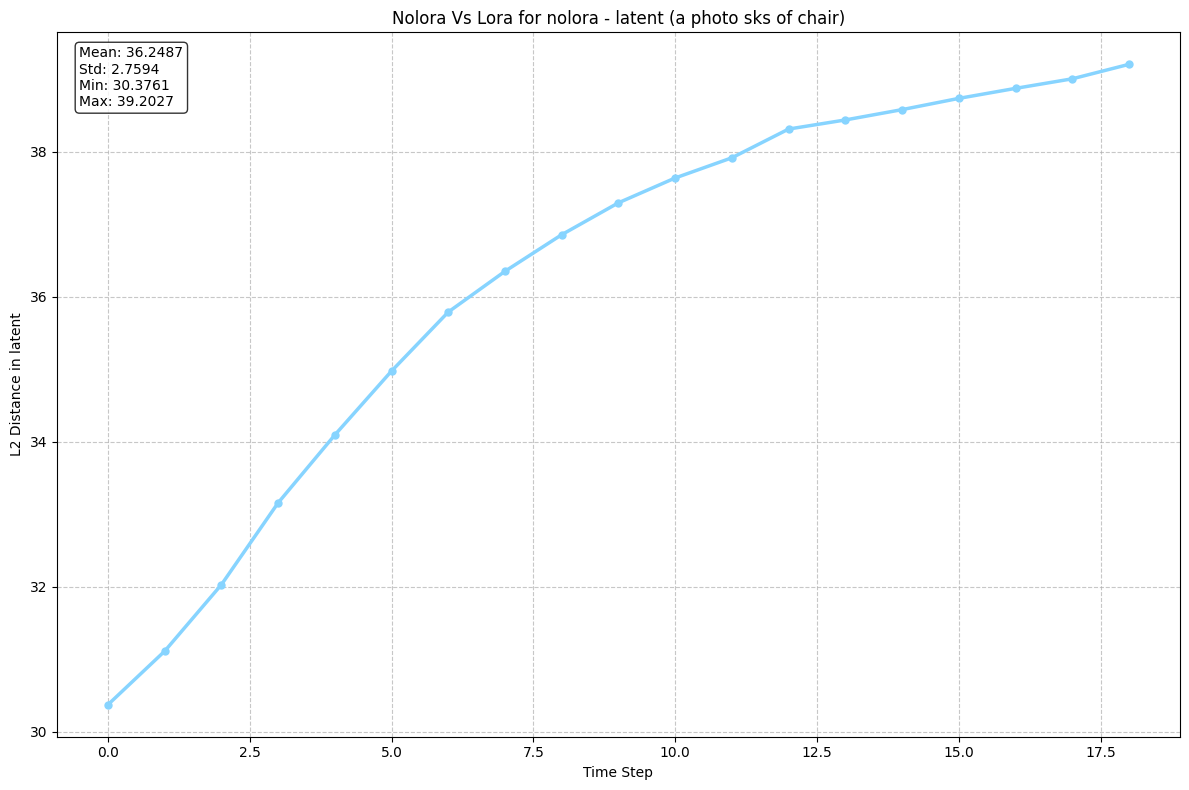

Statistics for nolora - nolora_vs_lora - latent (a photo sks of chair):
  Mean L2 distance: 36.2487
  Std deviation: 2.7594
  Min: 30.3761, Max: 39.2027



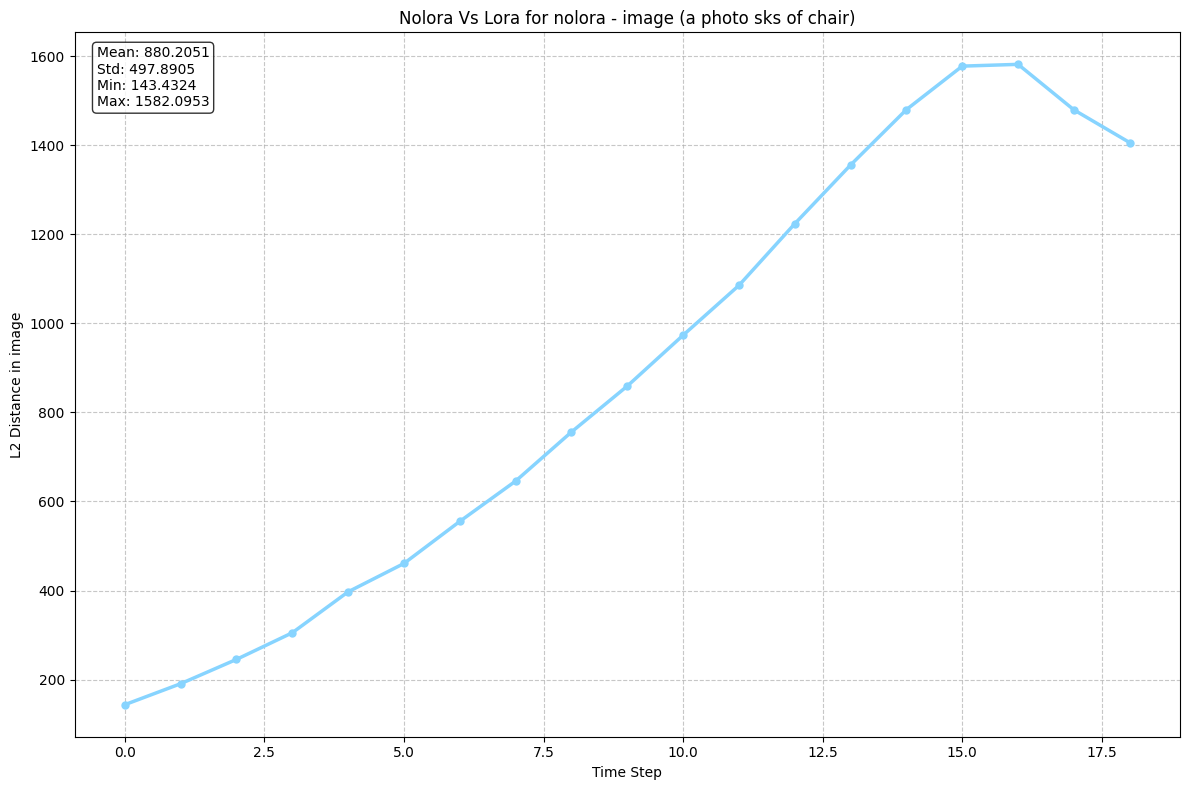

Statistics for nolora - nolora_vs_lora - image (a photo sks of chair):
  Mean L2 distance: 880.2051
  Std deviation: 497.8905
  Min: 143.4324, Max: 1582.0953



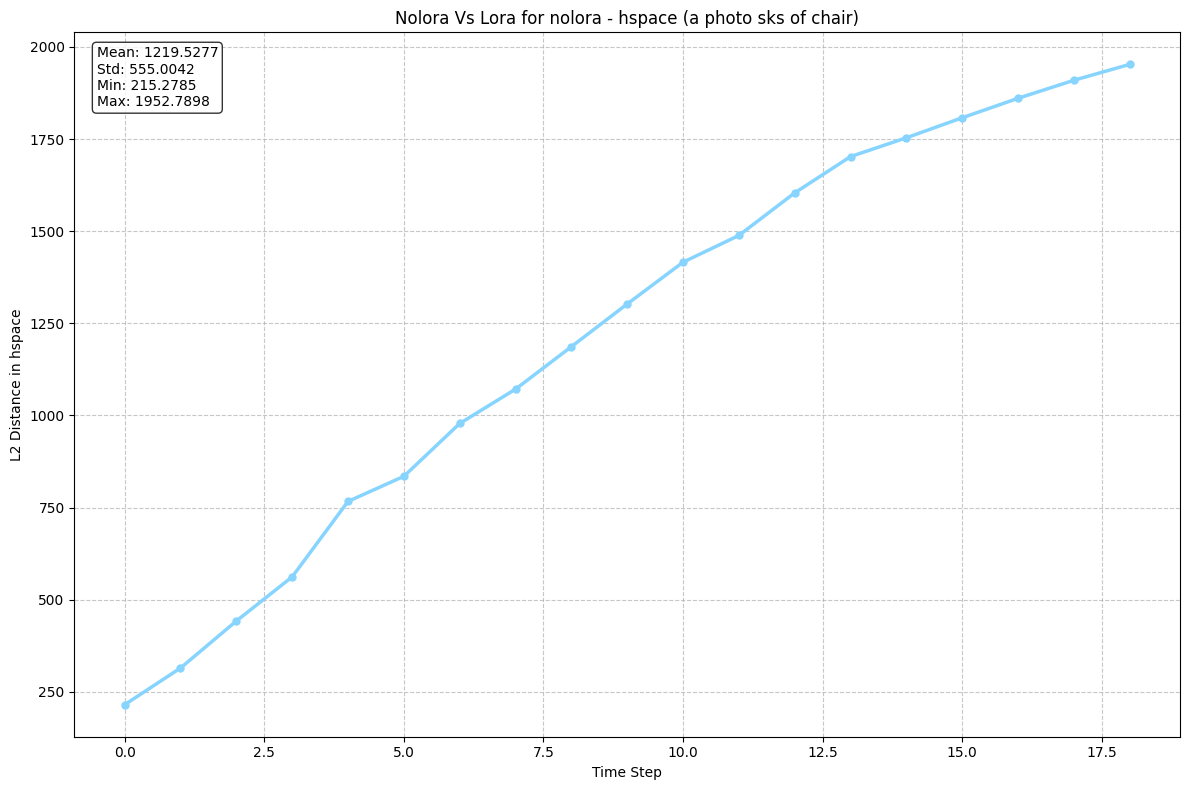

Statistics for nolora - nolora_vs_lora - hspace (a photo sks of chair):
  Mean L2 distance: 1219.5277
  Std deviation: 555.0042
  Min: 215.2785, Max: 1952.7898



In [26]:

# Calculate L2 distances between prefixes
l2_diff_data = calculate_l2_differences_between_prefixes(experiment_data)

# Plot the differences
plot_l2_difference_data(l2_diff_data)